# Generation and post-analysis in aids dataset

In [1]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import data_processing, visualization, statistic
import time
import pandas as pd
import warnings
from lifelines import CoxPHFitter
from tableone import TableOne
warnings.filterwarnings("ignore")

In [2]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.compare import compare_survival
from sksurv.nonparametric import kaplan_meier_estimator

from sksurv.util import Surv

In [3]:
%matplotlib inline

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

### Generate a sub sample of control

In [40]:
dataset_name = "Aids"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"

In [41]:
aids_control = pd.read_csv(data_file_control,header=None)
aids_control.columns = ["time","censor","strat2","sex","raceth","ivdrug","karnof","cd4","priorzdv","age"]
aids_control.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age
0,189,0,1,1,1,0,100,169.0,39.0,34
1,287,0,1,2,2,0,90,149.5,15.0,34
2,199,0,1,1,1,0,90,46.0,53.0,48
3,270,0,1,1,2,0,100,54.5,6.0,51
4,276,0,1,1,1,0,100,95.0,7.0,34


In [42]:
percent_forget=50
sampled_control_size=int(aids_control.shape[0]*percent_forget/100)
sampled_control = aids_control.sample(n=sampled_control_size, replace=False, random_state=42)

In [43]:
dataset_name = "Aids"
data_file= "./dataset/" + dataset_name + "/data_control_" + str(percent_forget) + ".csv"
sampled_control.to_csv(data_file,header=False,index=False)

### Experiment setting - links to data

In [44]:
dataset_name = "Aids"
data_file_control = "./dataset/" + dataset_name + "/data_control_" + str(percent_forget) + ".csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated = "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

## Statistical analysis with original data

In [45]:
aids_control = pd.read_csv(data_file_control,header=None)
aids_control.columns = ["time","censor","strat2","sex","raceth","ivdrug","karnof","cd4","priorzdv","age"]
aids_control.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age
0,88,0,1,1,2,0,90,37.0,6.0,35
1,252,0,1,2,2,0,90,130.0,30.0,32
2,151,1,0,1,1,0,70,38.0,45.0,47
3,300,0,1,1,3,0,90,126.0,36.0,32
4,292,0,1,1,2,0,90,118.5,11.0,44


In [46]:
aids_control.columns

Index(['time', 'censor', 'strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4',
       'priorzdv', 'age'],
      dtype='object')

In [47]:
aids_control_columns = pd.read_csv(feat_types_file_control)["name"].to_list()[1:]

In [48]:
aids_control_columns.insert(0, 'censor')
aids_control_columns.insert(0, 'time')
aids_control_columns

['time',
 'censor',
 'strat2',
 'sex',
 'raceth',
 'ivdrug',
 'karnof',
 'cd4',
 'priorzdv',
 'age']

### Data loading and Feature analysis treated/control

In [49]:
# Load training data
data_control, feat_types_dict, miss_mask_control, true_miss_mask_control, n_samples_control = data_processing.read_data(data_file_control, 
                                                                                                                        feat_types_file_control, 
                                                                                                                        miss_file, true_miss_file)
# Feature analysis
data_transformed_control = data_processing.discrete_variables_transformation(data_control, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

#visualization.plot_data(data_transformed_control, feat_types_dict)


In [50]:
feat_types_dict

[{'name': 'survcens', 'type': 'surv_weibull', 'dim': '2', 'nclass': ''},
 {'name': 'strat2', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'sex', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'raceth', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'ivdrug', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'karnof', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'cd4', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'priorzdv', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'age', 'type': 'real', 'dim': '1', 'nclass': ''}]

In [51]:
n_samples_control


288

In [52]:
# Load training data
data_treated, feat_types_dict, miss_mask_treated, true_miss_mask_treated, n_samples_treated = data_processing.read_data(data_file_treated, 
                                                                                                                        feat_types_file_treated, 
                                                                                                                        miss_file, true_miss_file)

# Feature analysis
data_transformed_treated = data_processing.discrete_variables_transformation(data_treated, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

#visualization.plot_data(data_transformed_treated, feat_types_dict)

In [53]:
df_transformed_treated = pd.DataFrame(data_transformed_treated.numpy(), columns=aids_control_columns)
df_transformed_control = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_treated["treatment"]=1
df_transformed_control["treatment"]=0
df_transformed_all = pd.concat([df_transformed_control, df_transformed_treated], ignore_index=True)

In [54]:
df_transformed_all.columns

Index(['time', 'censor', 'strat2', 'sex', 'raceth', 'ivdrug', 'karnof', 'cd4',
       'priorzdv', 'age', 'treatment'],
      dtype='object')

In [55]:
df_transformed_all.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age,treatment
0,88.0,0.0,1.0,0.0,1.0,0.0,2.0,37.0,6.0,35.0,0
1,252.0,0.0,1.0,1.0,1.0,0.0,2.0,130.0,30.0,32.0,0
2,151.0,1.0,0.0,0.0,0.0,0.0,0.0,38.0,45.0,47.0,0
3,300.0,0.0,1.0,0.0,2.0,0.0,2.0,126.0,36.0,32.0,0
4,292.0,0.0,1.0,0.0,1.0,0.0,2.0,118.5,11.0,44.0,0


In [56]:
df_transformed_all.shape

(862, 11)

In [57]:
feat_types_dict_all = feat_types_dict.copy()#

comparison variable treatment 10


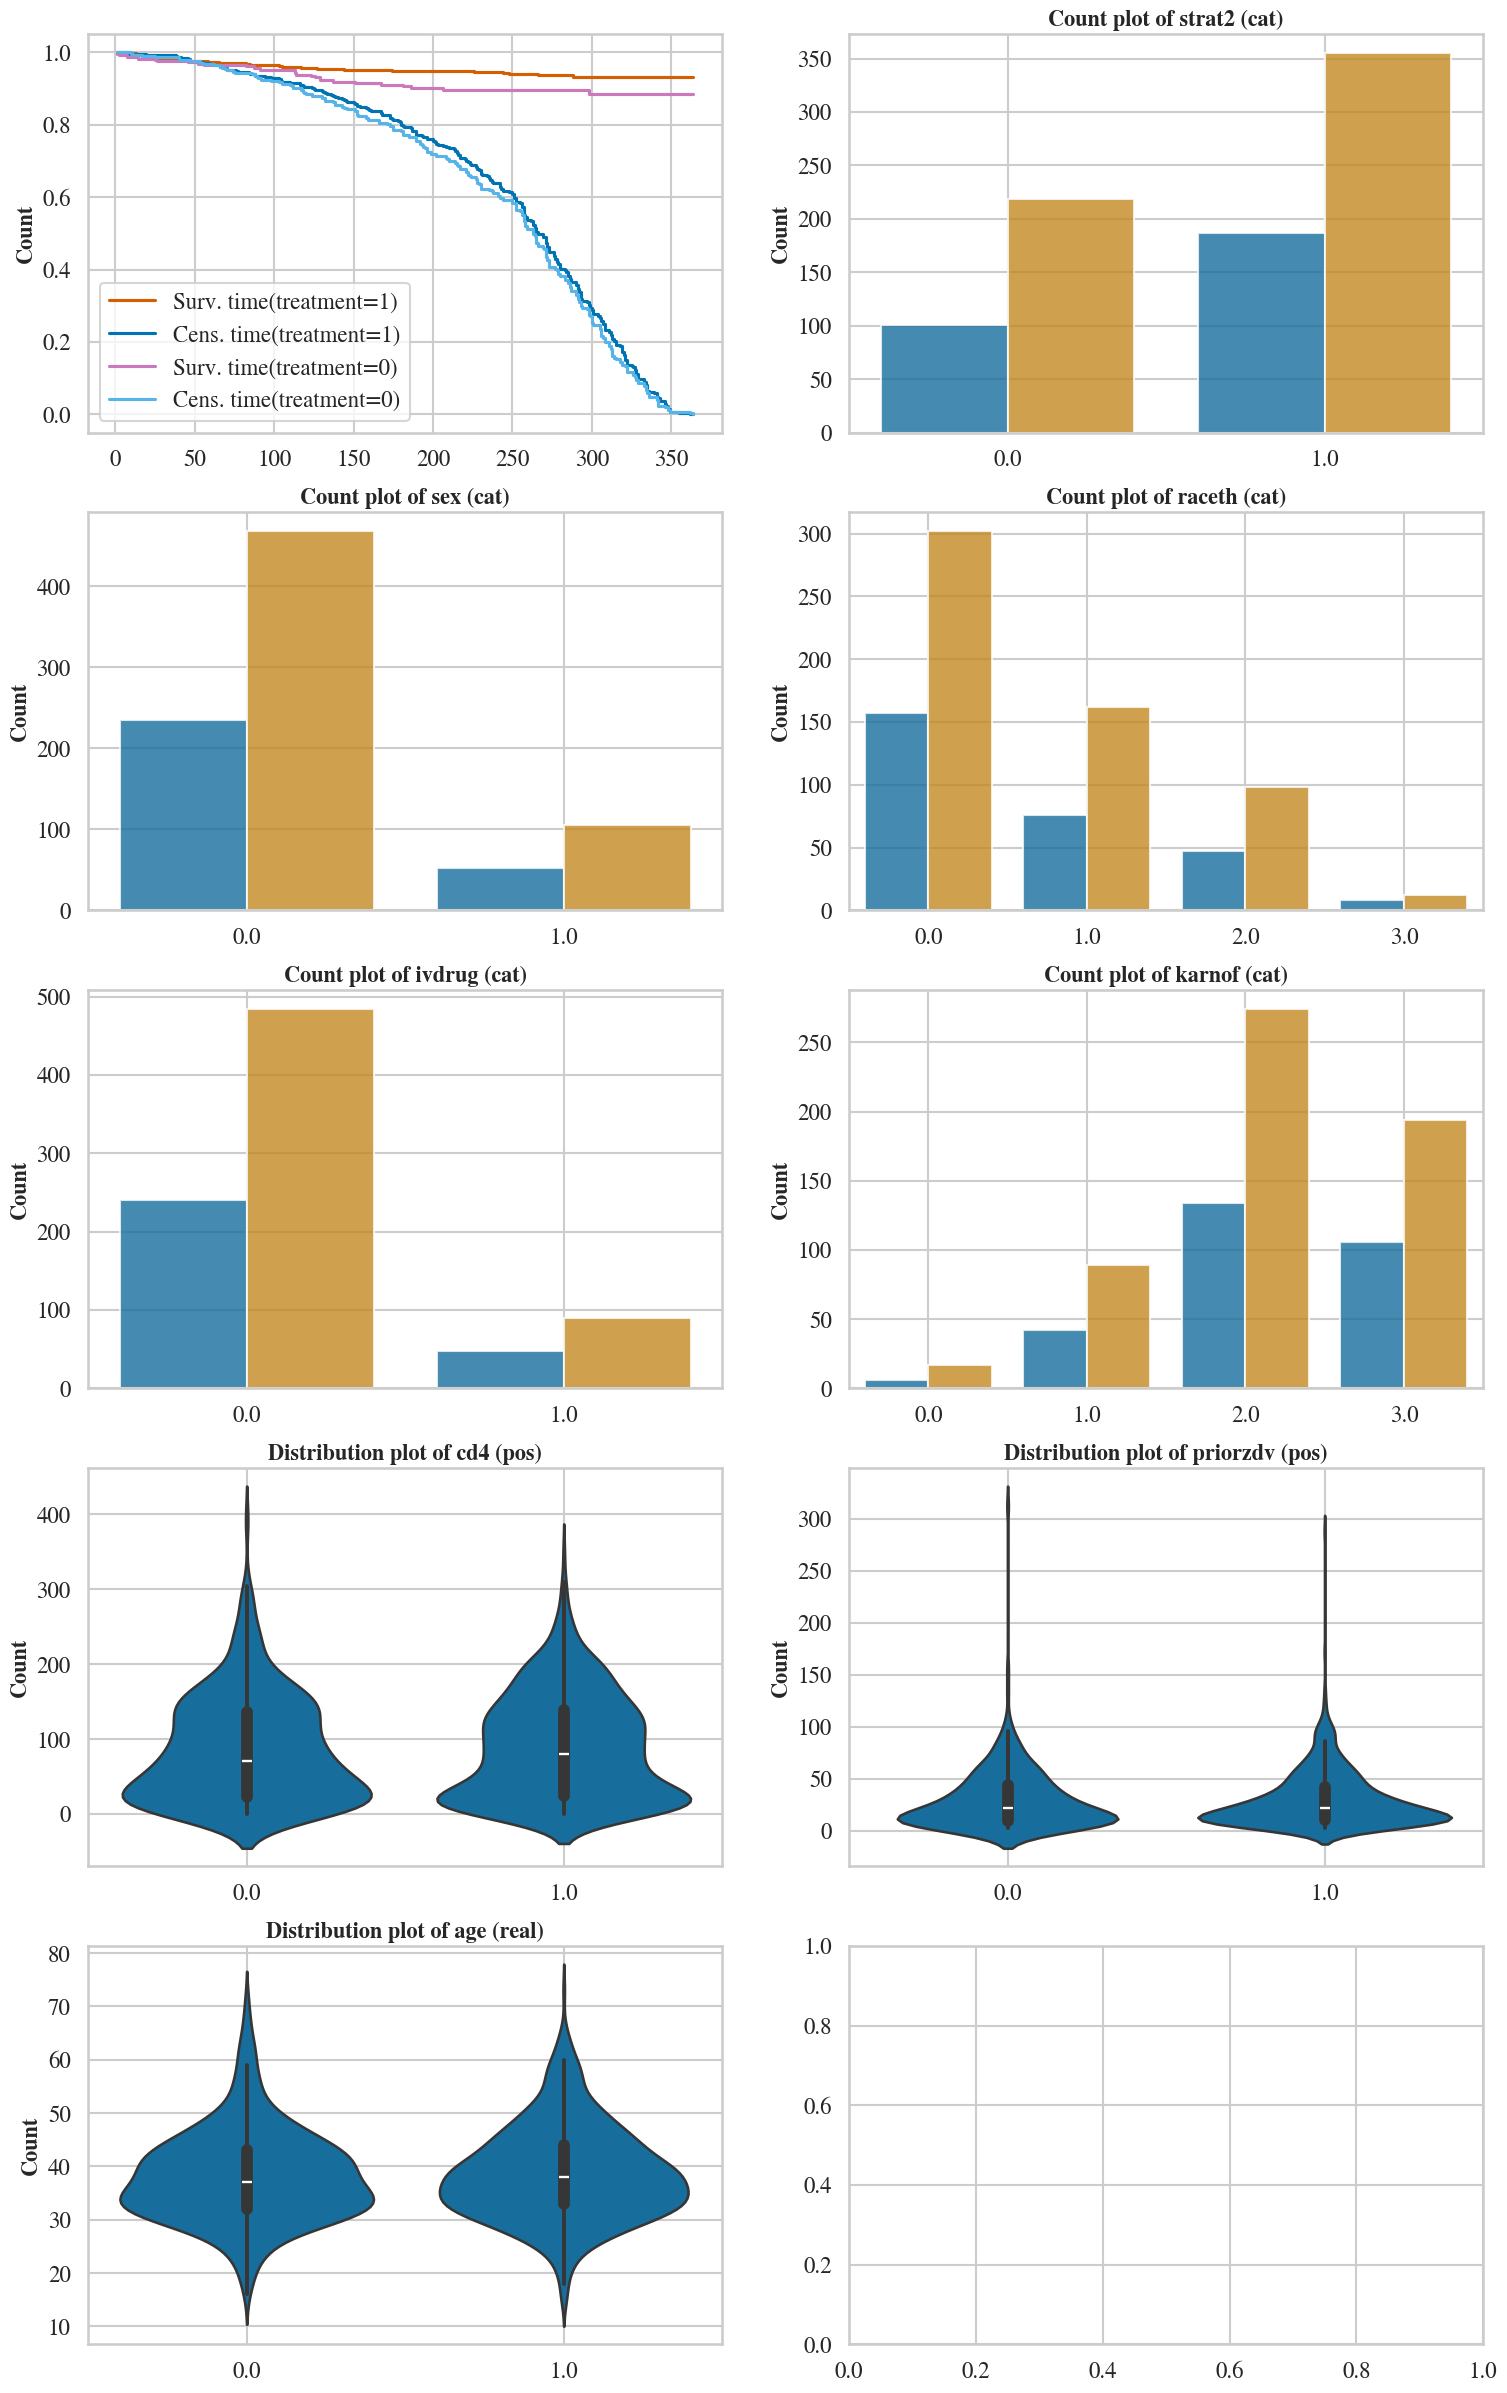

In [58]:
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_all.to_numpy(),feat_types_dict_all,feat_comparison_name = 'treatment')

In [59]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']

In [60]:
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                  862                  288                  574        
time, median [Q1,Q3]                            0  258.0 [179.2,301.0]  256.0 [158.8,298.0]  263.0 [187.0,305.0]   0.064
censor, n (%)            0.0                                801 (92.9)           260 (90.3)           541 (94.3)   0.045
                         1.0                                  61 (7.1)             28 (9.7)             33 (5.7)        
strat2, n (%)            0.0                                320 (37.1)           101 (35.1)           219 (38.2)   0.418
                         1.0                                542 (62.9)           187 (64.9)           355 (61.8)        
sex, n (%)               0.0    

In [61]:
miss_mask_control

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

## Training VAE

### Experiment setting

In [62]:
# Train-test split on control
data = data_control
miss_mask = miss_mask_control
true_miss_mask = true_miss_mask_control
feat_types_file = feat_types_file_control
train_test_share = .9
n_samples = data.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

data_train = data[train_index]
miss_mask_train = miss_mask[train_index]
true_miss_mask_train = true_miss_mask[train_index]

data_test = data[test_index]
miss_mask_test = miss_mask[test_index]
true_miss_mask_test = true_miss_mask[test_index]

# Adjust batch size if larger than dataset
batch_size = 100
batch_size = min(batch_size, n_train_samples)

# Number of batches
n_train_samples = data_train.shape[0]
n_batches_train = int(np.floor(n_train_samples / batch_size))
n_train_samples = n_batches_train * batch_size

# Compute real missing mask
miss_mask_train = torch.multiply(miss_mask_train, true_miss_mask_train)

# On test/val
n_test_samples = data_test.shape[0]
# Adjust batch size if larger than dataset
batch_test_size = n_test_samples
# Number of batches
n_batches_test = int(np.floor(n_test_samples / batch_test_size))

# Compute real missing mask
miss_mask_test = torch.multiply(miss_mask_test, true_miss_mask_test)
n_generated_sample = 10

### Model loading

In [63]:
import importlib
import os 

# model_name="HIVAE_factorized"
model_name="HIVAE_inputDropout"
dim_latent_z = 20
dim_latent_y = 15
dim_latent_s = 20
epochs = 1000
lr = 1e-3
save_file= "{}_{}_missing_{}_{}_z{}_y{}_s{}_batch_{}".format(model_name, dataset_name, m_perc, mask, dim_latent_z, dim_latent_y, dim_latent_s, batch_size)
# Create directories for saving models
save_dir = f'./saved_networks/{save_file}/'
os.makedirs(save_dir, exist_ok=True)
network_file = os.path.join(save_dir, f'{save_file}.pth')

# Create PyTorch HVAE model
model_loading = getattr(importlib.import_module("src"), model_name)
vae_model = model_loading(input_dim=data_train.shape[1], 
                          z_dim=dim_latent_z, 
                          y_dim=dim_latent_y, 
                          s_dim=dim_latent_s, 
                          y_dim_partition=None, 
                          feat_types_file=feat_types_file)

optimizer = optim.Adam(vae_model.parameters(), lr=lr)

### Train model

In [64]:
feat_types_dict

[{'name': 'survcens', 'type': 'surv_weibull', 'dim': '2', 'nclass': ''},
 {'name': 'strat2', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'sex', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'raceth', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'ivdrug', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'karnof', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'cd4', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'priorzdv', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'age', 'type': 'real', 'dim': '1', 'nclass': ''}]

Epoch: [ 0]  time: 0.1924, ELBO_train: -21.72144699, KL_z: 1.31431204, KL_s: 0.08352590, reconstruction loss: -20.32360905
Epoch: [100]  time: 2.1537, ELBO_train: -18.37470436, KL_z: 0.47732949, KL_s: 0.03108895, reconstruction loss: -17.86628592
Epoch: [200]  time: 4.2250, ELBO_train: -17.23286533, KL_z: 0.56691685, KL_s: 0.02185225, reconstruction loss: -16.64409623
Epoch: [300]  time: 6.1390, ELBO_train: -17.17276764, KL_z: 0.67690355, KL_s: 0.02441347, reconstruction loss: -16.47145063
Epoch: [400]  time: 8.0315, ELBO_train: -17.59213638, KL_z: 0.72386661, KL_s: 0.02578366, reconstruction loss: -16.84248611
Epoch: [500]  time: 9.9898, ELBO_train: -17.25344467, KL_z: 0.79695940, KL_s: 0.02652550, reconstruction loss: -16.42995977
Epoch: [600]  time: 11.9324, ELBO_train: -17.35485458, KL_z: 0.82003725, KL_s: 0.02575505, reconstruction loss: -16.50906229
Epoch: [700]  time: 14.2194, ELBO_train: -17.04462337, KL_z: 0.86521965, KL_s: 0.02815294, reconstruction loss: -16.15125078
Epoch: 

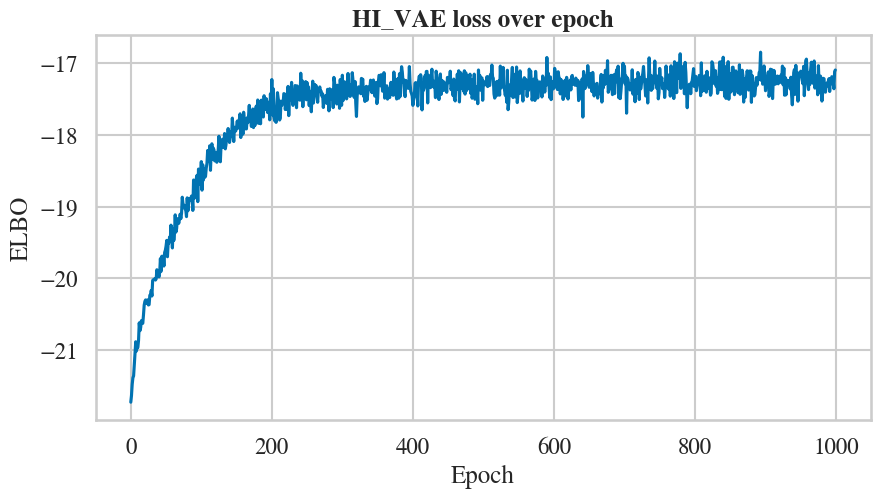

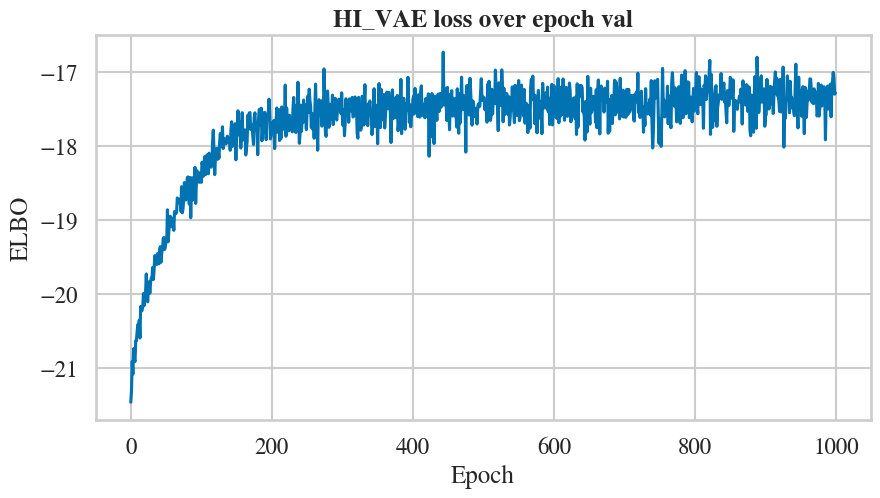

In [65]:
start_time = time.time()
loss_train, error_observed_train, error_missing_train = [], [], []
loss_val, error_observed_val, error_missing_val = [], [], []

rng = np.random.default_rng(seed=42)
for epoch in range(epochs):
    avg_loss, avg_KL_s, avg_KL_z = 0.0, 0.0, 0.0
    avg_loss_val, avg_KL_s_val, avg_KL_z_val = 0.0, 0.0, 0.0
    samples_list, p_params_list, q_params_list, log_p_x_total, log_p_x_missing_total = [], [], [], [], []
    tau = max(1.0 - 0.01 * epoch, 1e-3)

    # Shuffle training data
    perm = rng.permutation(data_train.shape[0])
    data_train = data_train[perm]
    miss_mask_train = miss_mask_train[perm]
    true_miss_mask_train = true_miss_mask_train[perm]

    for i in range(n_batches_train):
        # Get batch data
        data_list, miss_list = data_processing.next_batch(data_train, feat_types_dict, miss_mask_train, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]


        # Compute loss
        optimizer.zero_grad()
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau, n_generated_sample=1)
        vae_res["neg_ELBO_loss"].backward()
        optimizer.step()

        with torch.no_grad():

            avg_loss += vae_res["neg_ELBO_loss"].item() / n_batches_train
            avg_KL_s += torch.mean(vae_res["KL_s"]).item() / n_batches_train
            avg_KL_z += torch.mean(vae_res["KL_z"]).item() / n_batches_train
            # Number of samples generated by one input data

            

            
            for i in range(n_batches_test):
                data_list_test, miss_list_test = data_processing.next_batch(data_test, feat_types_dict, miss_mask_test, batch_test_size, i)
            
                # Mask unknown data (set unobserved values to zero)
                data_list_observed_test = [data * miss_list_test[:, i].view(batch_test_size, 1) for i, data in enumerate(data_list_test)]
            
                vae_res_test = vae_model.forward(data_list_observed_test, data_list_test, miss_list_test, tau=1e-3, n_generated_sample=1)
                avg_loss_val += vae_res_test["neg_ELBO_loss"].item() / n_batches_train
                avg_KL_s_val += torch.mean(vae_res_test["KL_s"]).item() / n_batches_train
                avg_KL_z_val += torch.mean(vae_res_test["KL_z"]).item() / n_batches_train
                #print(avg_loss_val)
            
            
     

        # Save the generated samlpes and estimated parameters !
        samples_list.append(vae_res["samples"])
        p_params_list.append(vae_res["p_params"])
        q_params_list.append(vae_res["q_params"])
        log_p_x_total.append(vae_res["log_p_x"])
        log_p_x_missing_total.append(vae_res["log_p_x_missing"])


    #Concatenate samples in arrays
    s_total, z_total, y_total, est_data_train = statistic.samples_concatenation(samples_list)
    
    # Transform discrete variables back to the original values
    data_train_transformed = data_processing.discrete_variables_transformation(data_train[: n_train_samples], feat_types_dict)
    est_data_train_transformed = data_processing.discrete_variables_transformation(est_data_train[0], feat_types_dict)
    # est_data_train_mean_imputed = statistic.mean_imputation(data_train_transformed, miss_mask_train[: n_train_samples], feat_types_dict)

    # Compute errors
    error_observed_samples, error_missing_samples = statistic.error_computation(data_train_transformed, est_data_train_transformed, 
                                                                                feat_types_dict, miss_mask[:n_train_samples])
    
    # # #Create global dictionary of the distribution parameters
    q_params_complete = statistic.q_distribution_params_concatenation(q_params_list)
    
    #Number of clusters created
    cluster_index = torch.argmax(q_params_complete['s'], 1)
    cluster = torch.unique(cluster_index)
    #print('Clusters: ' + str(len(cluster)))

    # Save average loss and error
    loss_train.append(avg_loss)
    loss_val.append(avg_loss_val)
    error_observed_train.append(torch.mean(error_observed_samples))
    error_missing_train.append(torch.mean(error_missing_samples))
    if epoch % 100 == 0:
        visualization.print_loss(epoch, start_time, -avg_loss, avg_KL_s, avg_KL_z)

print("Training finished.")

torch.save(vae_model.state_dict(), network_file)

visualization.plot_loss_evolution(-np.array(loss_train), title = "HI_VAE loss over epoch",
                                xlabel = "Epoch", ylabel = "ELBO")
visualization.plot_loss_evolution(-np.array(loss_val), title = "HI_VAE loss over epoch val",
                                xlabel = "Epoch", ylabel = "ELBO")


In [49]:
#visualization.plot_loss_evolution(np.array(error_observed_train), title = "Error on observed data",
#                                xlabel = "Epoch", ylabel = "AvgErr")
#visualization.plot_loss_evolution(np.array(error_missing_train), title = "Error on missing data",
#                                xlabel = "Epoch", ylabel = "AvgErr")

## Generated samples from control dataset

In [66]:
data.shape

torch.Size([288, 19])

In [67]:
data_forgen = data#[train_index]
miss_mask_forgen = miss_mask#[train_index]
true_miss_mask_forgen = true_miss_mask#[train_index]

In [68]:
miss_mask_forgen.shape

torch.Size([288, 9])

In [69]:
data_forgen.shape

torch.Size([288, 19])

#### Generate from original sample

In [70]:
n_samples_forgen = data_forgen.shape[0]
batch_size = n_samples_forgen
print(n_samples_forgen)
# Number of batches
n_batches_generation = 1

# Compute real missing mask
miss_mask_forgen = torch.multiply(miss_mask_forgen, true_miss_mask_forgen)

# Number of samples generated by one input data
n_generated_sample = 100

with torch.no_grad(): 
    
    error_mode_global = 0.0
    avg_loss = 0.0
    samples_list = []
    
    for i in range(n_batches_generation):
        data_list, miss_list = data_processing.next_batch(data_forgen, feat_types_dict, miss_mask_forgen, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]
        
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3, n_generated_sample=n_generated_sample)
        samples_list.append(vae_res["samples"])
    
    
    #Concatenate samples in arrays
    est_data_gen = statistic.samples_concatenation(samples_list)[-1]
    est_data_gen_transformed = []
    for j in range(n_generated_sample):
        data_trans = data_processing.discrete_variables_transformation(est_data_gen[j], feat_types_dict)
        data_trans = data_processing.survival_variables_transformation(data_trans,feat_types_dict)
        est_data_gen_transformed.append(data_trans.unsqueeze(0))
        
    est_data_gen_transformed = torch.cat(est_data_gen_transformed, dim=0)

288


In [103]:
est_data_gen_transformed[3].numpy()

array([[181.10857 ,   0.      ,   1.      , ...,  19.924498,  22.221216,
         34.477715],
       [364.      ,   0.      ,   1.      , ...,  36.92656 ,  10.548913,
         38.033966],
       [ 83.56631 ,   0.      ,   0.      , ...,   6.639218,  59.251743,
         24.835018],
       ...,
       [246.99797 ,   0.      ,   0.      , ...,  10.820299,  27.36178 ,
         32.114037],
       [294.11063 ,   0.      ,   1.      , ..., 321.23346 ,  17.884296,
         39.295998],
       [124.07817 ,   0.      ,   1.      , ...,  17.219154,   6.486814,
         27.397444]], dtype=float32)

### Statistical analysis with simulated vs initial control data

In [104]:
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[3].numpy(), columns=aids_control_columns)
df_transformed_initial["sample"]=1
df_transformed_generated["sample"]=0
df_transformed_initial_generated = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

In [105]:
df_transformed_generated

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age,sample
0,181.108566,0.0,1.0,0.0,0.0,0.0,2.0,19.924498,22.221216,34.477715,0
1,364.000000,0.0,1.0,1.0,1.0,0.0,3.0,36.926559,10.548913,38.033966,0
2,83.566307,0.0,0.0,1.0,0.0,0.0,2.0,6.639218,59.251743,24.835018,0
3,204.367447,0.0,0.0,0.0,2.0,0.0,2.0,76.180466,22.642370,36.138252,0
4,277.971863,0.0,0.0,0.0,0.0,0.0,2.0,23.635826,7.150970,34.352879,0
...,...,...,...,...,...,...,...,...,...,...,...
283,310.576721,0.0,1.0,0.0,0.0,0.0,2.0,6.680725,37.733120,39.879200,0
284,210.193741,0.0,0.0,0.0,1.0,0.0,1.0,4.167531,9.696719,43.130779,0
285,246.997971,0.0,0.0,0.0,0.0,1.0,2.0,10.820299,27.361780,32.114037,0
286,294.110626,0.0,1.0,0.0,0.0,0.0,3.0,321.233459,17.884296,39.295998,0


comparison variable sample 10


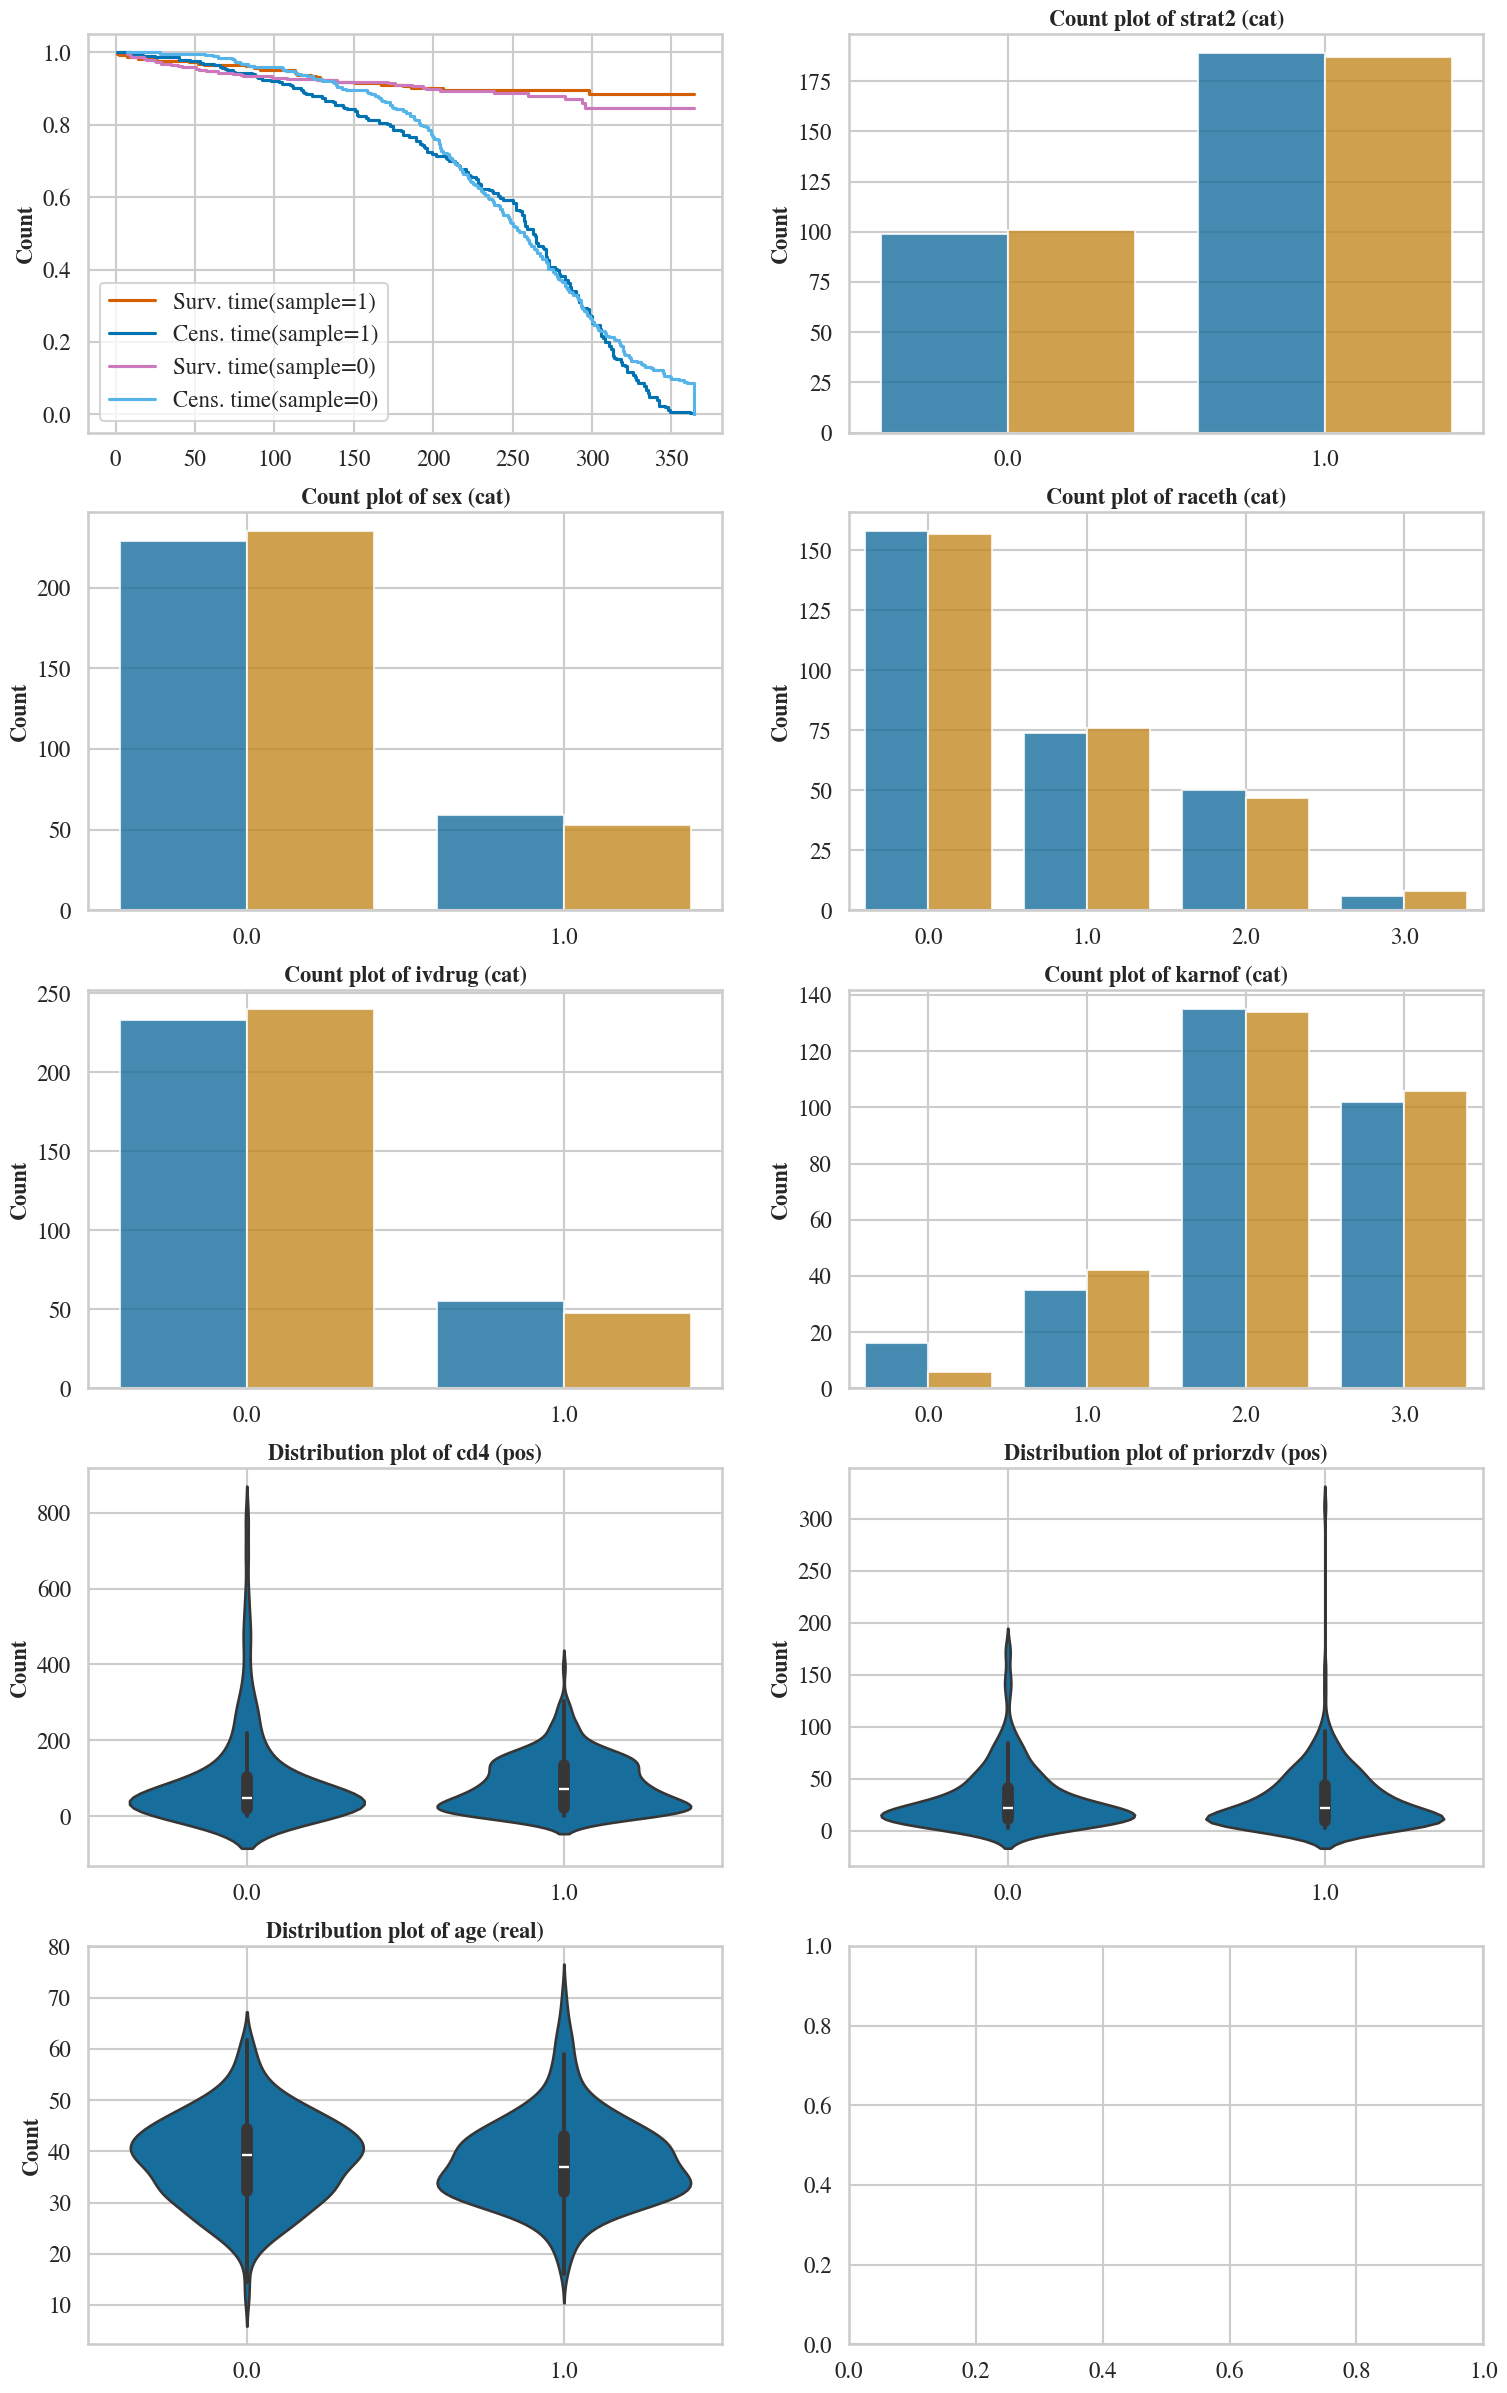

In [106]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_initial_generated.to_numpy(),feat_types_dict_all,feat_comparison_name = 'sample')

In [107]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','sample']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']

In [108]:
table1 = TableOne(df_transformed_initial_generated, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by sample                                                                       
                                       Missing              Overall                    0                    1 P-Value
n                                                               576                  288                  288        
time, median [Q1,Q3]                         0  249.6 [175.0,296.9]  243.3 [186.5,294.4]  256.0 [158.8,298.0]   0.698
censor, n (%)            0.0                             514 (89.2)           254 (88.2)           260 (90.3)   0.501
                         1.0                              62 (10.8)            34 (11.8)             28 (9.7)        
strat2, n (%)            0.0                             200 (34.7)            99 (34.4)           101 (35.1)   0.930
                         1.0                             376 (65.3)           189 (65.6)           187 (64.9)        
sex, n (%)               0.0                            

### Statistical analysis: generated control x initial treated

In [109]:
df_transformed_initial_generated=df_transformed_initial_generated.drop(columns='sample')
df_transformed_initial_generated['treatment'] = 0
df_transformed_initial_generated.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age,treatment
0,88.0,0.0,1.0,0.0,1.0,0.0,2.0,37.0,6.0,35.0,0
1,252.0,0.0,1.0,1.0,1.0,0.0,2.0,130.0,30.0,32.0,0
2,151.0,1.0,0.0,0.0,0.0,0.0,0.0,38.0,45.0,47.0,0
3,300.0,0.0,1.0,0.0,2.0,0.0,2.0,126.0,36.0,32.0,0
4,292.0,0.0,1.0,0.0,1.0,0.0,2.0,118.5,11.0,44.0,0


In [110]:
df_transformed_treated.head()

,time,censor,strat2,sex,raceth,ivdrug,karnof,cd4,priorzdv,age,treatment
0,242.0,0.0,0.0,0.0,0.0,0.0,3.0,23.5,9.0,20.0,1
1,286.0,0.0,0.0,0.0,0.0,1.0,2.0,10.0,12.0,46.0,1
2,285.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,51.0,1
3,285.0,0.0,1.0,0.0,1.0,1.0,1.0,117.5,24.0,40.0,1
4,334.0,0.0,0.0,1.0,2.0,0.0,2.0,7.5,62.0,38.0,1


In [111]:
#df_transformed_generated = pd.DataFrame(est_data_gen_transformed[2].numpy(), columns=aids_control_columns)
#df_transformed_generated['treatment'] = 0
df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_initial_generated], ignore_index=True)
#df_transformed_T_Cgen = df_transformed_T_Cgen.drop('sample',axis=1)
#df_transformed_T_Cgen.head()

In [112]:
df_transformed_initial_generated.shape

(576, 11)

In [113]:
#df_transformed_all.head()

In [114]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                  862                  288                  574        
time, median [Q1,Q3]                            0  258.0 [179.2,301.0]  256.0 [158.8,298.0]  263.0 [187.0,305.0]   0.064
censor, n (%)            0.0                                801 (92.9)           260 (90.3)           541 (94.3)   0.045
                         1.0                                  61 (7.1)             28 (9.7)             33 (5.7)        
strat2, n (%)            0.0                                320 (37.1)           101 (35.1)           219 (38.2)   0.418
                         1.0                                542 (62.9)           187 (64.9)           355 (61.8)        
sex, n (%)               0.0    

In [115]:
table1 = TableOne(df_transformed_T_Cgen, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                             Grouped by treatment                                                                       
                                          Missing              Overall                    0                    1 P-Value
n                                                                 1150                  576                  574        
time, median [Q1,Q3]                            0  257.0 [180.2,300.0]  249.6 [175.0,296.9]  263.0 [187.0,305.0]   0.044
censor, n (%)            0.0                               1055 (91.7)           514 (89.2)           541 (94.3)   0.003
                         1.0                                  95 (8.3)            62 (10.8)             33 (5.7)        
strat2, n (%)            0.0                                419 (36.4)           200 (34.7)           219 (38.2)   0.251
                         1.0                                731 (63.6)           376 (65.3)           355 (61.8)        
sex, n (%)               0.0    

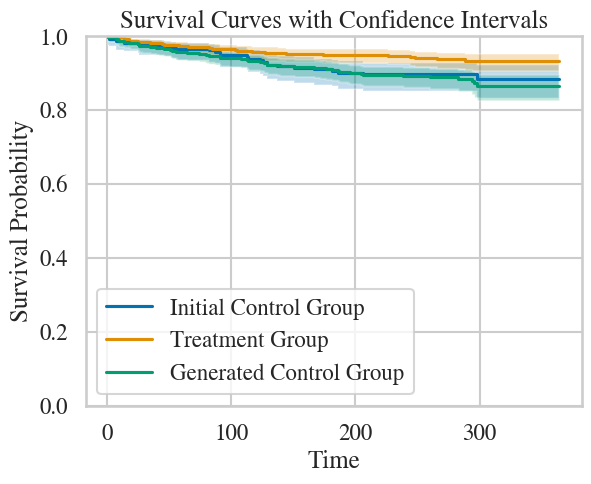

In [116]:

time_initial_C, survival_prob_initial_C, conf_int_initial_C = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_initial_T, survival_prob_initial_T, conf_int_initial_T = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_C, survival_prob_T_Cgen_C, conf_int_T_Cgen_C = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_T, survival_prob_T_Cgen_T, conf_int_T_Cgen_T = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)


plt.step(time_initial_C, survival_prob_initial_C, where="post", label="Initial Control Group")
plt.fill_between(time_initial_C, conf_int_initial_C[0], conf_int_initial_C[1], alpha=0.25, step="post")

plt.step(time_initial_T, survival_prob_initial_T, where="post", label="Treatment Group")
plt.fill_between(time_initial_T, conf_int_initial_T[0], conf_int_initial_T[1], alpha=0.25, step="post")


plt.step(time_T_Cgen_C, survival_prob_T_Cgen_C, where="post", label="Generated Control Group")
plt.fill_between(time_T_Cgen_C, conf_int_T_Cgen_C[0], conf_int_T_Cgen_C[1], alpha=0.25, step="post")


#plt.step(time_T_Cgen_T, survival_prob_T_Cgen_T, where="post")
#plt.fill_between(time_T_Cgen_T, conf_int_T_Cgen_T[0], conf_int_T_Cgen_T[1], alpha=0.25, step="post")

plt.ylim(0, 1)

# Add legend
plt.legend()

# Optional: add axis labels and title
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")

# Show the plot
plt.show()

## Tests

In [65]:
categorical_encode = ['strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']

Initial Cox model

In [66]:
df_transformed_all_oh = df_transformed_all.copy()
for feat in categorical_encode:
    df_transformed_all_oh = data_processing.encode_and_bind(df_transformed_all_oh,feat)
X_initial = df_transformed_all_oh.to_numpy()[:,2:15]
Y_initial = Surv.from_arrays(df_transformed_all_oh.to_numpy()[:,1]==1,df_transformed_all_oh.to_numpy()[:,0])    

In [67]:
number_column_treatment = 6 # in X_initial

In [68]:
cox_initial = CoxPHSurvivalAnalysis()
cox_initial.fit(X_initial,Y_initial)
cox_initial.coef_

array([-1.51111787e-02,  2.03117243e-01, -5.55172796e-01, -1.46215358e-02,
       -7.93512048e-04,  2.40314802e-02, -6.66311702e-01, -3.46774177e-01,
        1.18200430e-01,  6.34223907e-01, -5.20579406e-01, -1.18117777e+00,
       -1.58299670e+00])

Tests in all generated datasets

In [69]:
coef_treat = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
for i in np.arange(n_generated_sample):
    #print(i)
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=aids_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = data_processing.encode_and_bind(df_transformed_T_Cgen_oh,feat)
    
    X_T_Cgen = df_transformed_T_Cgen_oh.to_numpy()[:,2:15]
    Y_T_Cgen = Surv.from_arrays(df_transformed_T_Cgen_oh.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh.to_numpy()[:,0])
    coef_treat[i,0] = -np.log(compare_survival(Y_T_Cgen,X_T_Cgen[:,number_column_treatment])[1])
    cox_generated = CoxPHSurvivalAnalysis()
    cox_generated.fit(X_T_Cgen,Y_T_Cgen)
    coef_treat[i,1:] = cox_generated.coef_[:]


In [70]:
df_transformed_all_oh.columns

Index(['time', 'censor', 'strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
       'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0', 'karnof1.0',
       'karnof2.0', 'karnof3.0'],
      dtype='object')

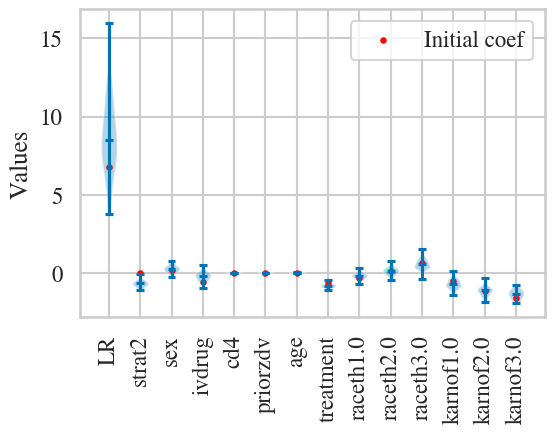

In [71]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial,X_initial[:,number_column_treatment])[1])
y_values[1:] = cox_initial.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(['LR','strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
                   'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0',
                    'karnof1.0', 'karnof2.0', 'karnof3.0'])
ax.set_ylabel("Values")
ax.legend()

plt.show()

### Log rank test

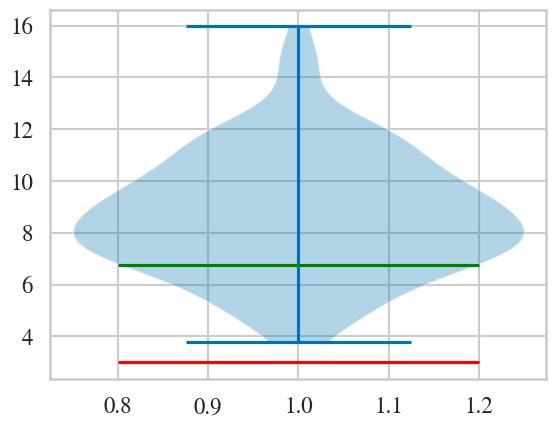

In [72]:
plt.violinplot(coef_treat[:,0])#,
plt.hlines(y_values[0],0.8,1.2,color='green')
plt.hlines(-np.log(0.05),0.8,1.2,color='red')

### Test coefficient traitement (Cox)

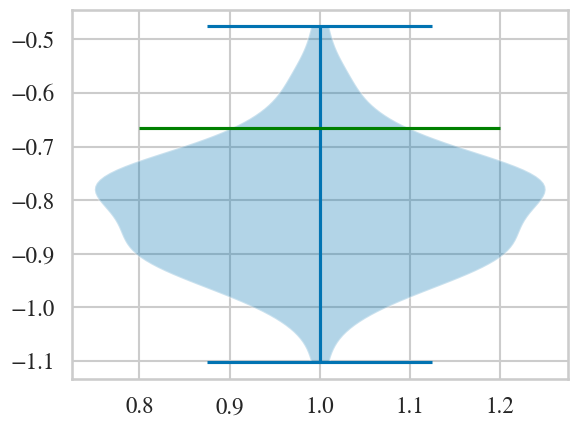

In [73]:
plt.violinplot(coef_treat[:,number_column_treatment+1])#,
plt.hlines(y_values[7],0.8,1.2,color='green')

## Stratified w.r. CD4 count analysis

In [74]:
data_trans

tensor([[351.9079,   0.0000,   1.0000,  ..., 229.8221,  81.0849,  48.1227],
        [296.2031,   0.0000,   1.0000,  ...,  26.1832,  13.5399,  31.8009],
        [ 70.6679,   0.0000,   1.0000,  ..., 533.4196,  43.8417,  32.2609],
        ...,
        [205.1988,   0.0000,   0.0000,  ...,  26.5795,  10.3279,  31.5081],
        [334.1815,   0.0000,   1.0000,  ..., 153.9997, 196.5486,  46.4357],
        [264.1260,   0.0000,   1.0000,  ..., 408.9958,  48.0222,  48.9979]])

In [75]:
df_transformed_all_oh = df_transformed_all.copy()
for feat in categorical_encode:
    df_transformed_all_oh = data_processing.encode_and_bind(df_transformed_all_oh,feat)
X_initial = df_transformed_all_oh.to_numpy()[:,2:15]
Y_initial = Surv.from_arrays(df_transformed_all_oh.to_numpy()[:,1]==1,df_transformed_all_oh.to_numpy()[:,0])    

In [76]:
cd4_threshold = 50
df_transformed_all_oh_lowcd4 = df_transformed_all_oh[df_transformed_all_oh['cd4'] <= cd4_threshold]
print(df_transformed_all_oh_lowcd4.shape)
X_initial_lowcd4 = df_transformed_all_oh_lowcd4.to_numpy()[:,2:15]
Y_initial_lowcd4 = Surv.from_arrays(df_transformed_all_oh_lowcd4.to_numpy()[:,1]==1,df_transformed_all_oh_lowcd4.to_numpy()[:,0]) 
df_transformed_all_oh_highcd4 = df_transformed_all_oh[df_transformed_all_oh['cd4'] > cd4_threshold]
print(df_transformed_all_oh_highcd4.shape)
X_initial_highcd4 = df_transformed_all_oh_highcd4.to_numpy()[:,2:15]
Y_initial_highcd4 = Surv.from_arrays(df_transformed_all_oh_highcd4.to_numpy()[:,1]==1,df_transformed_all_oh_highcd4.to_numpy()[:,0]) 

(459, 15)
(692, 15)


In [77]:
cox_initial_lowcd4 = CoxPHSurvivalAnalysis()
cox_initial_lowcd4.fit(X_initial_lowcd4,Y_initial_lowcd4)
cox_initial_highcd4 = CoxPHSurvivalAnalysis()
cox_initial_highcd4.fit(X_initial_highcd4,Y_initial_highcd4)


CoxPHSurvivalAnalysis()

In [78]:
feat_types_dict_all

[{'name': 'survcens', 'type': 'surv_weibull', 'dim': '2', 'nclass': ''},
 {'name': 'strat2', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'sex', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'raceth', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'ivdrug', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'karnof', 'type': 'cat', 'dim': '1', 'nclass': '4'},
 {'name': 'cd4', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'priorzdv', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'age', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'}]

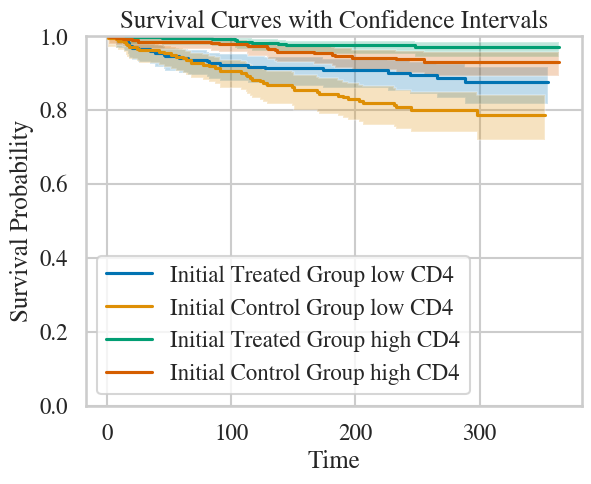

In [79]:
time_initial_lowcd4_T, survival_prob_initial_lowcd4_T, conf_int_initial_lowcd4_T = kaplan_meier_estimator(
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)

time_initial_lowcd4_C, survival_prob_initial_lowcd4_C, conf_int_initial_lowcd4_C = kaplan_meier_estimator(
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all_oh_lowcd4[df_transformed_all_oh_lowcd4['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_initial_highcd4_T, survival_prob_initial_highcd4_T, conf_int_initial_highcd4_T = kaplan_meier_estimator(
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)


time_initial_highcd4_C, survival_prob_initial_highcd4_C, conf_int_initial_highcd4_C = kaplan_meier_estimator(
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all_oh_highcd4[df_transformed_all_oh_highcd4['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

plt.step(time_initial_lowcd4_T, survival_prob_initial_lowcd4_T, where="post", label="Initial Treated Group low CD4")
plt.fill_between(time_initial_lowcd4_T, conf_int_initial_lowcd4_T[0], conf_int_initial_lowcd4_T[1], alpha=0.25, step="post")

plt.step(time_initial_lowcd4_C, survival_prob_initial_lowcd4_C, where="post", label="Initial Control Group low CD4")
plt.fill_between(time_initial_lowcd4_C, conf_int_initial_lowcd4_C[0], conf_int_initial_lowcd4_C[1], alpha=0.25, step="post")

plt.step(time_initial_highcd4_T, survival_prob_initial_highcd4_T, where="post", label="Initial Treated Group high CD4")
plt.fill_between(time_initial_highcd4_T, conf_int_initial_highcd4_T[0], conf_int_initial_highcd4_T[1], alpha=0.25, step="post")

plt.step(time_initial_highcd4_C, survival_prob_initial_highcd4_C, where="post", label="Initial Control Group high CD4")
plt.fill_between(time_initial_highcd4_C, conf_int_initial_highcd4_C[0], conf_int_initial_highcd4_C[1], alpha=0.25, step="post")


#plt.step(time_T_Cgen_T, survival_prob_T_Cgen_T, where="post")
#plt.fill_between(time_T_Cgen_T, conf_int_T_Cgen_T[0], conf_int_T_Cgen_T[1], alpha=0.25, step="post")

plt.ylim(0, 1)

# Add legend
plt.legend()

# Optional: add axis labels and title
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")

# Show the plot
plt.show()

In [80]:
compare_survival(Y_initial_lowcd4,X_initial_lowcd4[:,number_column_treatment])

(5.535873093721627, 0.018630467405504746)

In [64]:
compare_survival(Y_initial_highcd4,X_initial_highcd4[:,number_column_treatment])

(4.395519026726351, 0.036033490142707805)

In [65]:
coef_treat_lowcd4 = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
coef_treat_highcd4 = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
for i in np.arange(n_generated_sample):
    #print(i)
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=aids_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = data_processing.encode_and_bind(df_transformed_T_Cgen_oh,feat)
    
    df_transformed_T_Cgen_oh_lowcd4 = df_transformed_T_Cgen_oh[df_transformed_T_Cgen_oh['cd4'] <= cd4_threshold]
    X_gen_lowcd4 = df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,2:15]
    Y_gen_lowcd4 = Surv.from_arrays(df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh_lowcd4.to_numpy()[:,0]) 
    df_transformed_T_Cgen_oh_highcd4 = df_transformed_T_Cgen_oh[df_transformed_T_Cgen_oh['cd4'] > cd4_threshold]
    X_gen_highcd4 = df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,2:15]
    Y_gen_highcd4 = Surv.from_arrays(df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh_highcd4.to_numpy()[:,0]) 
    
    coef_treat_lowcd4[i,0] = -np.log(compare_survival(Y_gen_lowcd4,X_gen_lowcd4[:,number_column_treatment])[1])
    cox_generated_lowcd4 = CoxPHSurvivalAnalysis()
    cox_generated_lowcd4.fit(X_gen_lowcd4,Y_gen_lowcd4)
    coef_treat_lowcd4[i,1:] = cox_generated_lowcd4.coef_[:]

    coef_treat_highcd4[i,0] = -np.log(compare_survival(Y_gen_highcd4,X_gen_highcd4[:,number_column_treatment])[1])
    cox_generated_highcd4 = CoxPHSurvivalAnalysis()
    cox_generated_highcd4.fit(X_gen_highcd4,Y_gen_highcd4)
    coef_treat_highcd4[i,1:] = cox_generated_highcd4.coef_[:]


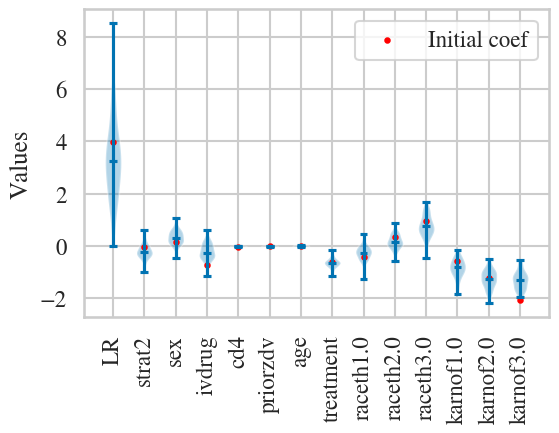

In [66]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat_lowcd4, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat_lowcd4.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat_lowcd4.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial_lowcd4,X_initial_lowcd4[:,number_column_treatment])[1])
y_values[1:] = cox_initial_lowcd4.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(['LR','strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
                   'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0',
                    'karnof1.0', 'karnof2.0', 'karnof3.0'])
ax.set_ylabel("Values")
ax.legend()

plt.show()

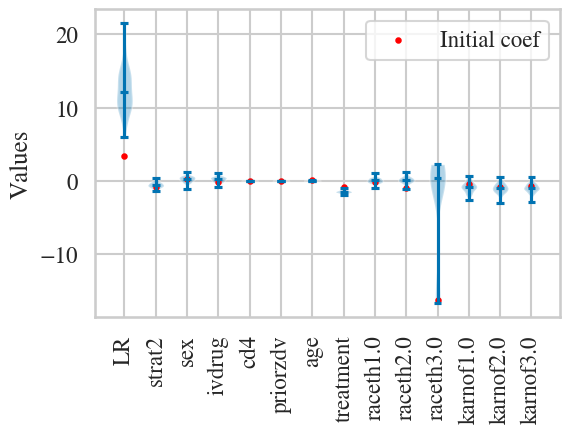

In [67]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat_highcd4, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat_highcd4.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat_highcd4.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial_highcd4,X_initial_highcd4[:,number_column_treatment])[1])
y_values[1:] = cox_initial_highcd4.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(['LR','strat2', 'sex', 'ivdrug', 'cd4', 'priorzdv', 'age',
                   'treatment', 'raceth1.0', 'raceth2.0', 'raceth3.0',
                    'karnof1.0', 'karnof2.0', 'karnof3.0'])
ax.set_ylabel("Values")
ax.legend()

plt.show()

In [68]:

compare_survival(Y_gen_highcd4,X_gen_highcd4[:,number_column_treatment])

(9.216454049243636, 0.002398496416092953)

# Generation with Survival GAN with preprocessing from Agathe

In [87]:
from lifelines.datasets import load_rossi
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.plugins import Plugins

X = df_transformed_control #preprocessed dataset

data = SurvivalAnalysisDataLoader(
    X,
    target_column="censor",
    time_to_event_column="time",
)


In [88]:
syn_model = Plugins().get("survival_gan") # possibility to change to ['survae', 'survival_ctgan', 'survival_gan', 'survival_nflow']

syn_model.fit(data)

control_testmodel = syn_model.generate(count=577)

[2025-04-07T16:32:32.590048+0200][182299][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-04-07T16:32:32.783322+0200][182299][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 11%|████▏                                 | 1099/10000 [02:47<22:39,  6.55it/s]


In [89]:
control_testmodel['treatment']=1
df_control_testmodel = pd.DataFrame(control_testmodel.numpy(), columns=df_transformed_control.columns)
df_transformed_all = pd.concat([df_transformed_control, df_control_testmodel], ignore_index=True)

comparison variable treatment 10


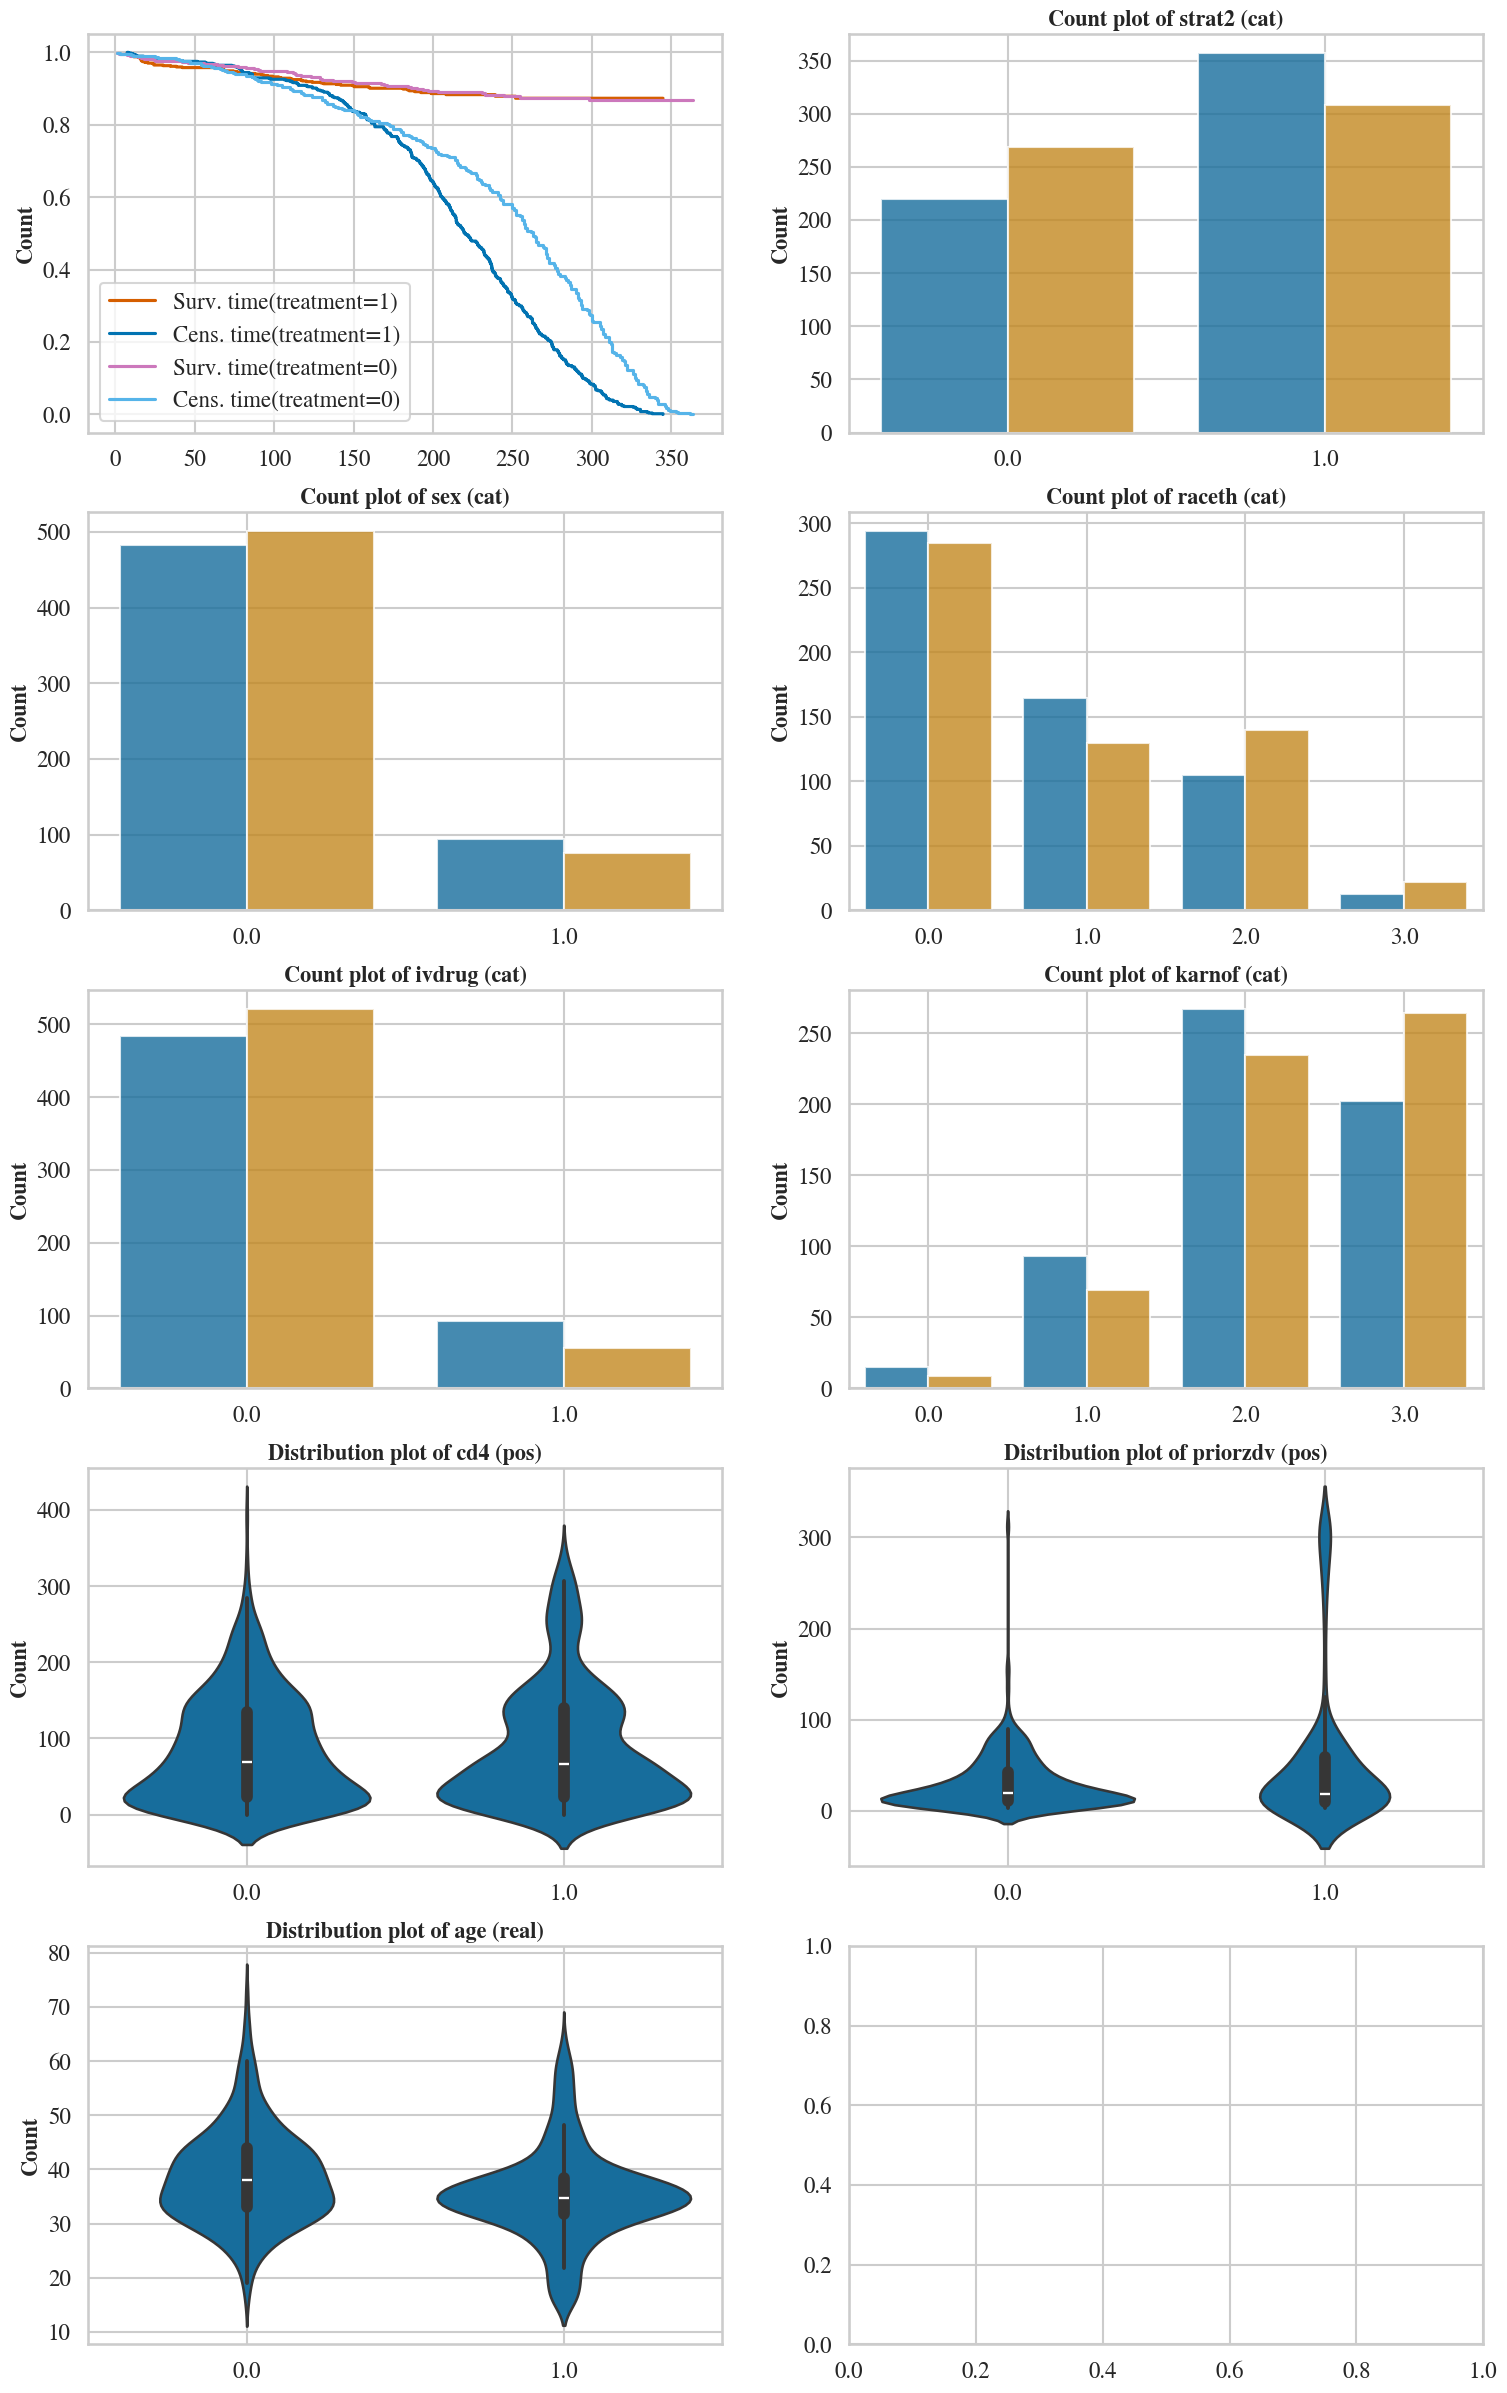

In [90]:
feat_types_dict_all = feat_types_dict.copy()#
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_all.to_numpy(),feat_types_dict_all,feat_comparison_name = 'treatment')

# Generation with Survival GAN without preprocessing (preprocessing from synthcity)

In [91]:
from lifelines.datasets import load_rossi
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.plugins import Plugins

X = aids_control #Original (lightly preprocessed dataset)

data = SurvivalAnalysisDataLoader(
    X,
    target_column="censor",
    time_to_event_column="time",
)

In [92]:
syn_model = Plugins().get("survival_gan") # possibility to change to ['survae', 'survival_ctgan', 'survival_gan', 'survival_nflow']

syn_model.fit(data)

control_testmodel = syn_model.generate(count=577)

[2025-04-07T16:35:22.513803+0200][182299][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-04-07T16:35:22.687066+0200][182299][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  3%|█▏                                     | 299/10000 [00:45<24:50,  6.51it/s]


In [93]:
aids_control['treatment']=0
control_testmodel['treatment']=1
df_control_testmodel = pd.DataFrame(control_testmodel.numpy(), columns=aids_control.columns)
df_transformed_all = pd.concat([aids_control, df_control_testmodel], ignore_index=True)

comparison variable treatment 10


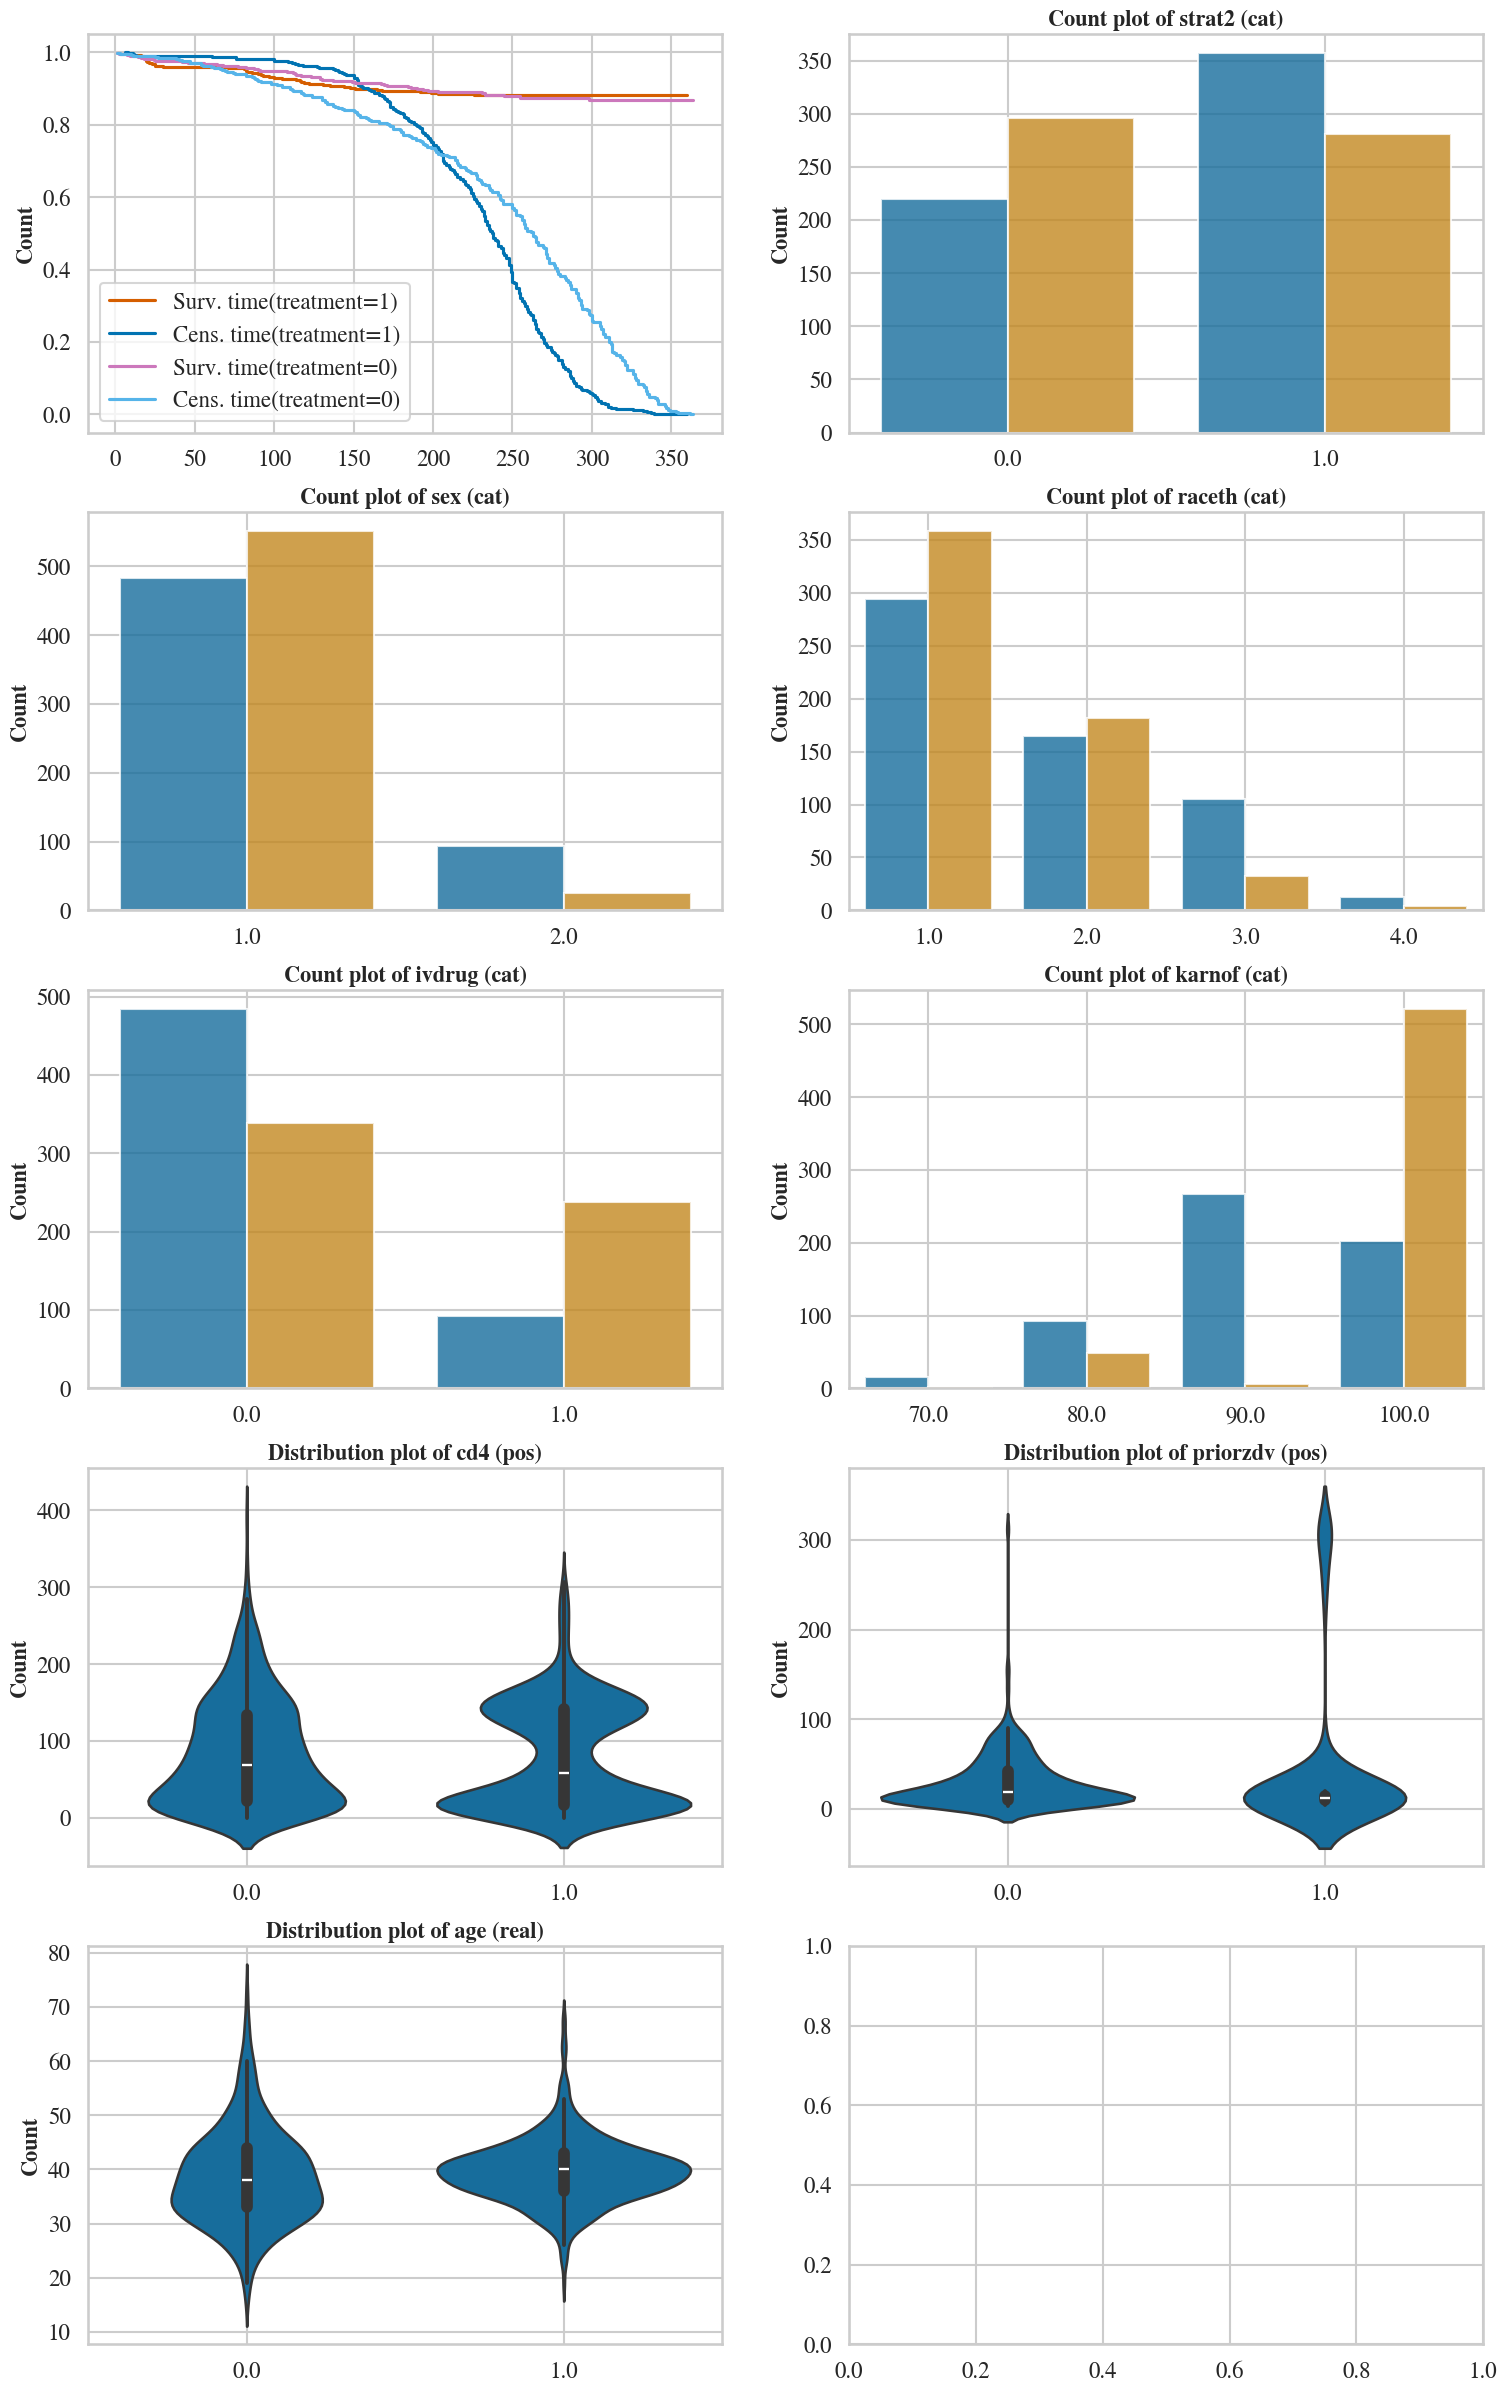

In [94]:
feat_types_dict_all = feat_types_dict.copy()#
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_all.to_numpy(),feat_types_dict_all,feat_comparison_name = 'treatment')

# Generation with SurVAE with preprocessing from Agathe

In [99]:
from lifelines.datasets import load_rossi
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.plugins import Plugins

X = df_transformed_control #preprocessed dataset

data = SurvivalAnalysisDataLoader(
    X,
    target_column="censor",
    time_to_event_column="time",
)


In [100]:
syn_model = Plugins().get("survae") # possibility to change to ['survae', 'survival_ctgan', 'survival_gan', 'survival_nflow']

syn_model.fit(data)

control_testmodel = syn_model.generate(count=577)

[2025-04-07T16:39:01.947628+0200][182299][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-04-07T16:39:01.967135+0200][182299][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████                          | 350/1000 [01:10<02:10,  4.97it/s]


In [101]:
control_testmodel['treatment']=1
df_control_testmodel = pd.DataFrame(control_testmodel.numpy(), columns=df_transformed_control.columns)
df_transformed_all = pd.concat([df_transformed_control, df_control_testmodel], ignore_index=True)

comparison variable treatment 10


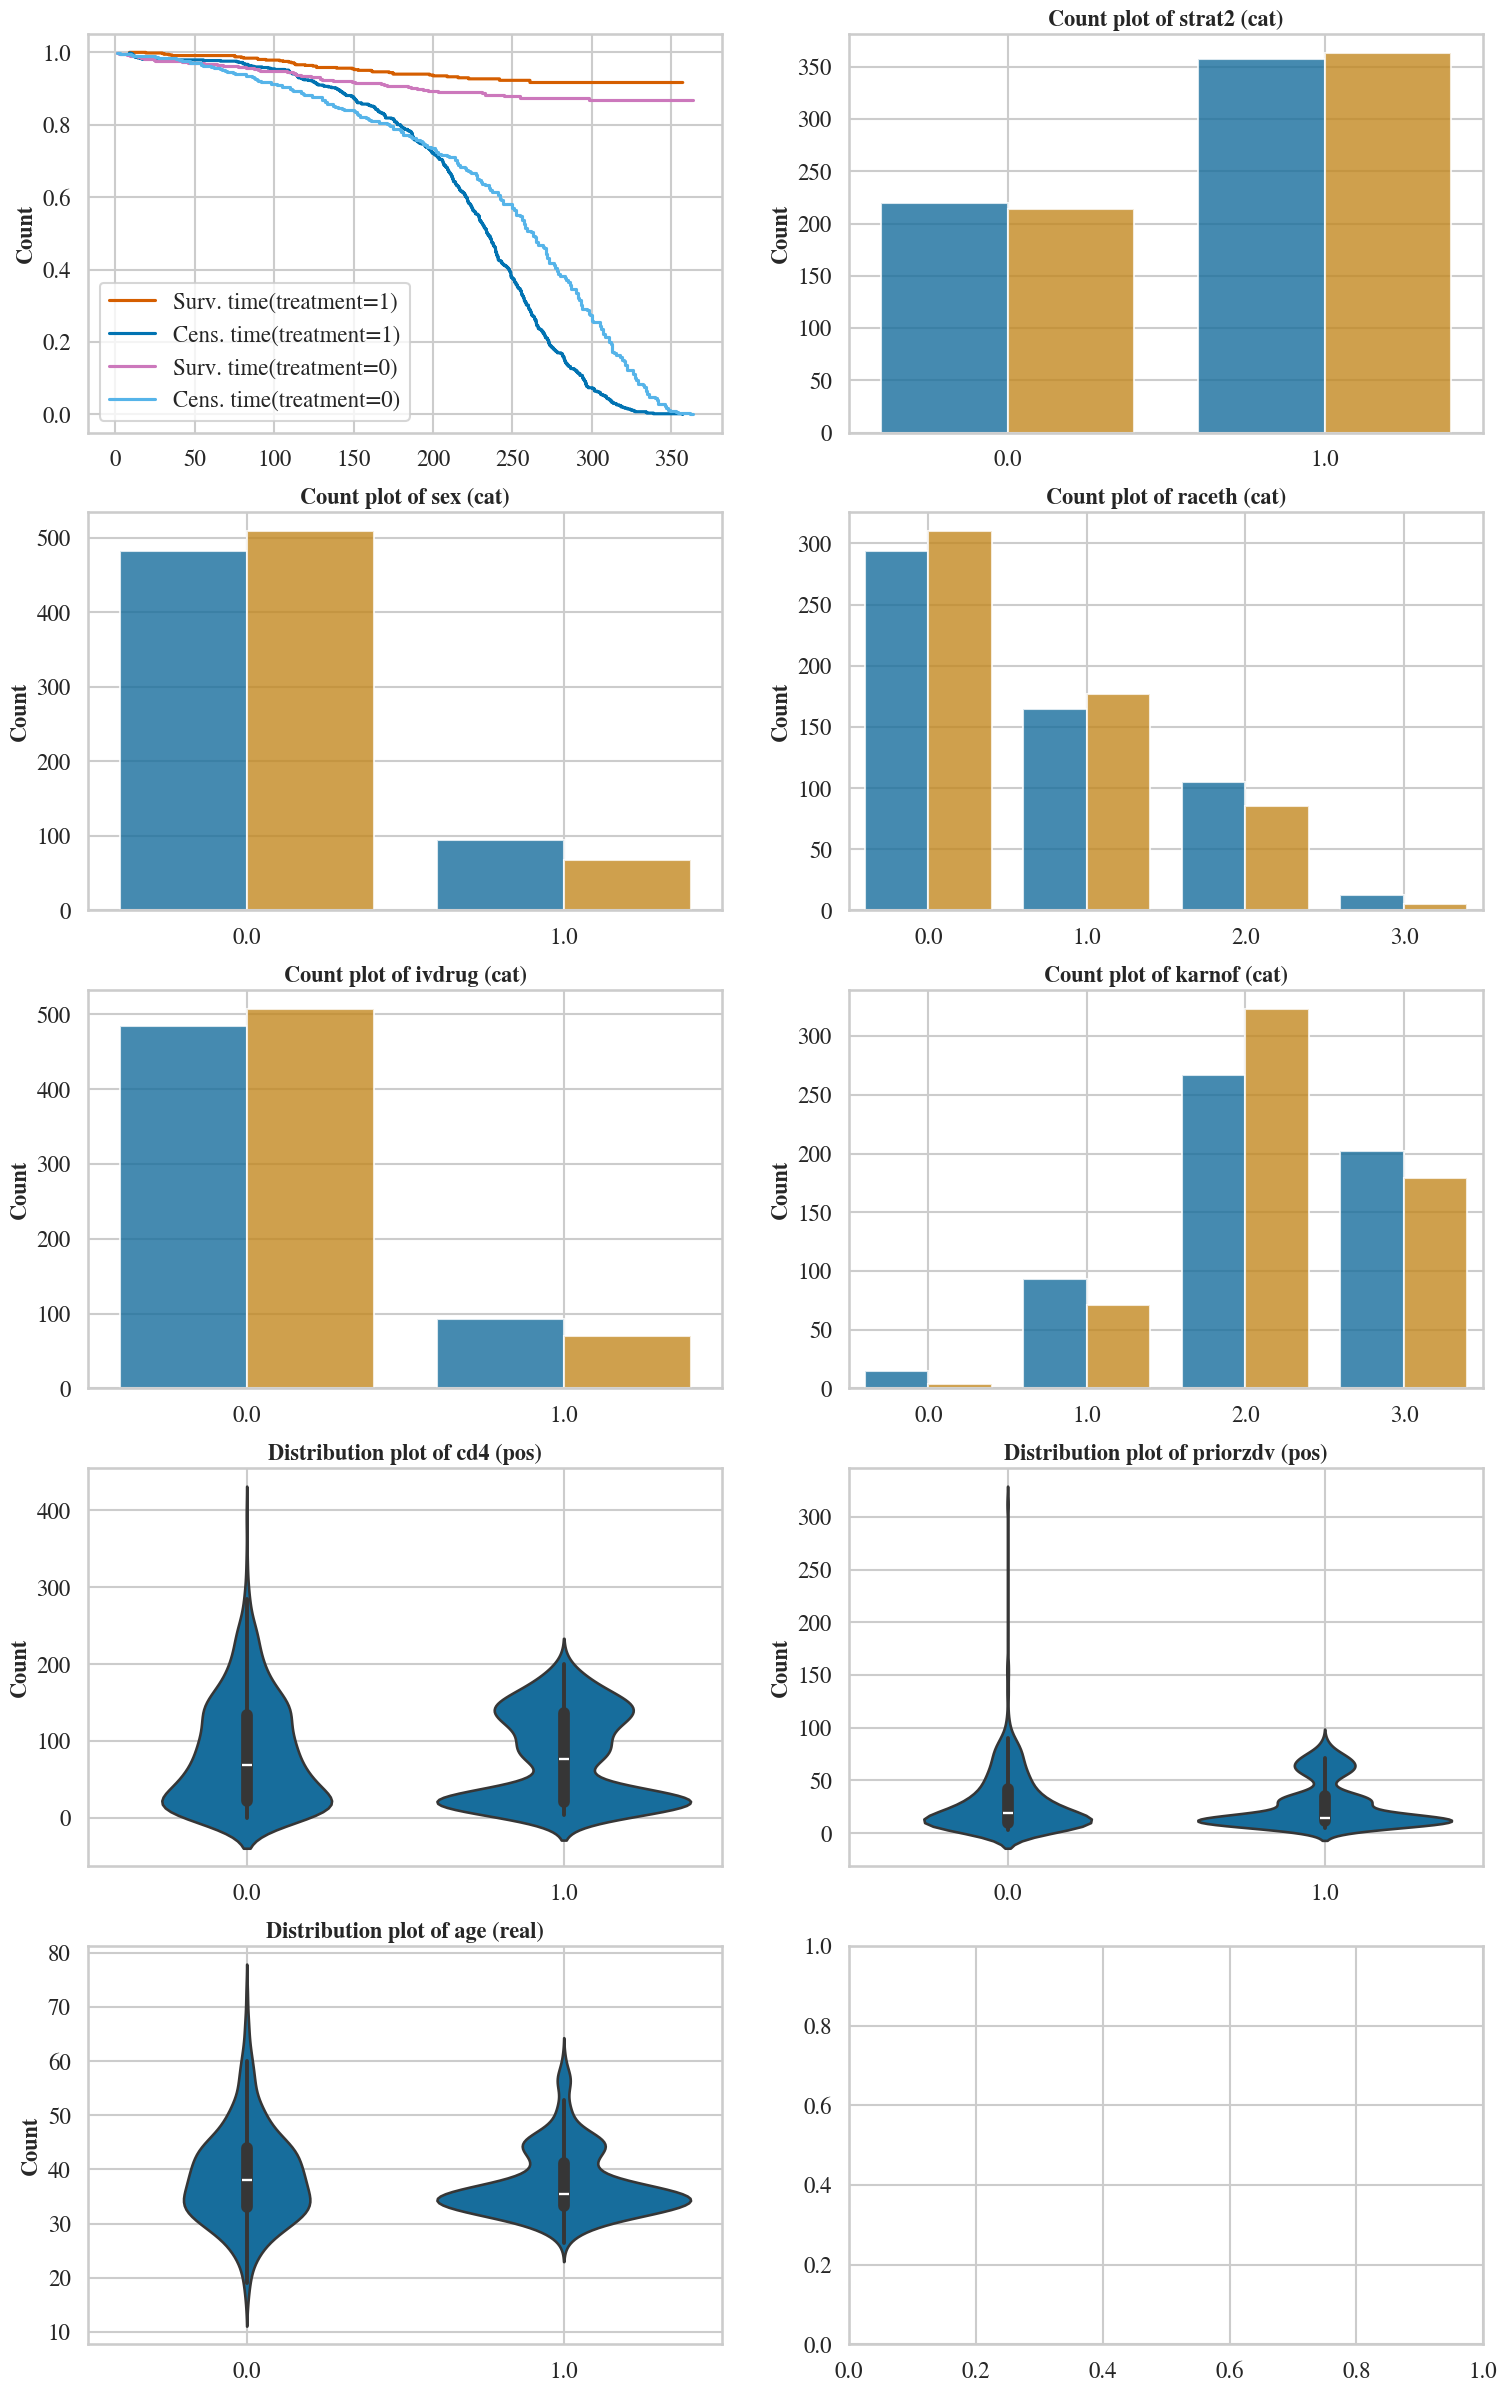

In [102]:
feat_types_dict_all = feat_types_dict.copy()#
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_all.to_numpy(),feat_types_dict_all,feat_comparison_name = 'treatment')

# Generation with SurVAE without preprocessing

In [95]:
from lifelines.datasets import load_rossi
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.plugins import Plugins

X = aids_control #Original (lightly preprocessed dataset)

data = SurvivalAnalysisDataLoader(
    X,
    target_column="censor",
    time_to_event_column="time",
)

In [96]:
syn_model = Plugins().get("survae") # possibility to change to ['survae', 'survival_ctgan', 'survival_gan', 'survival_nflow']

syn_model.fit(data)

control_testmodel = syn_model.generate(count=577)

[2025-04-07T16:36:10.773631+0200][182299][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-04-07T16:36:10.785637+0200][182299][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████                          | 350/1000 [01:00<01:53,  5.74it/s]


In [97]:
aids_control['treatment']=0
control_testmodel['treatment']=1
df_control_testmodel = pd.DataFrame(control_testmodel.numpy(), columns=aids_control.columns)
df_transformed_all = pd.concat([aids_control, df_control_testmodel], ignore_index=True)

comparison variable treatment 10


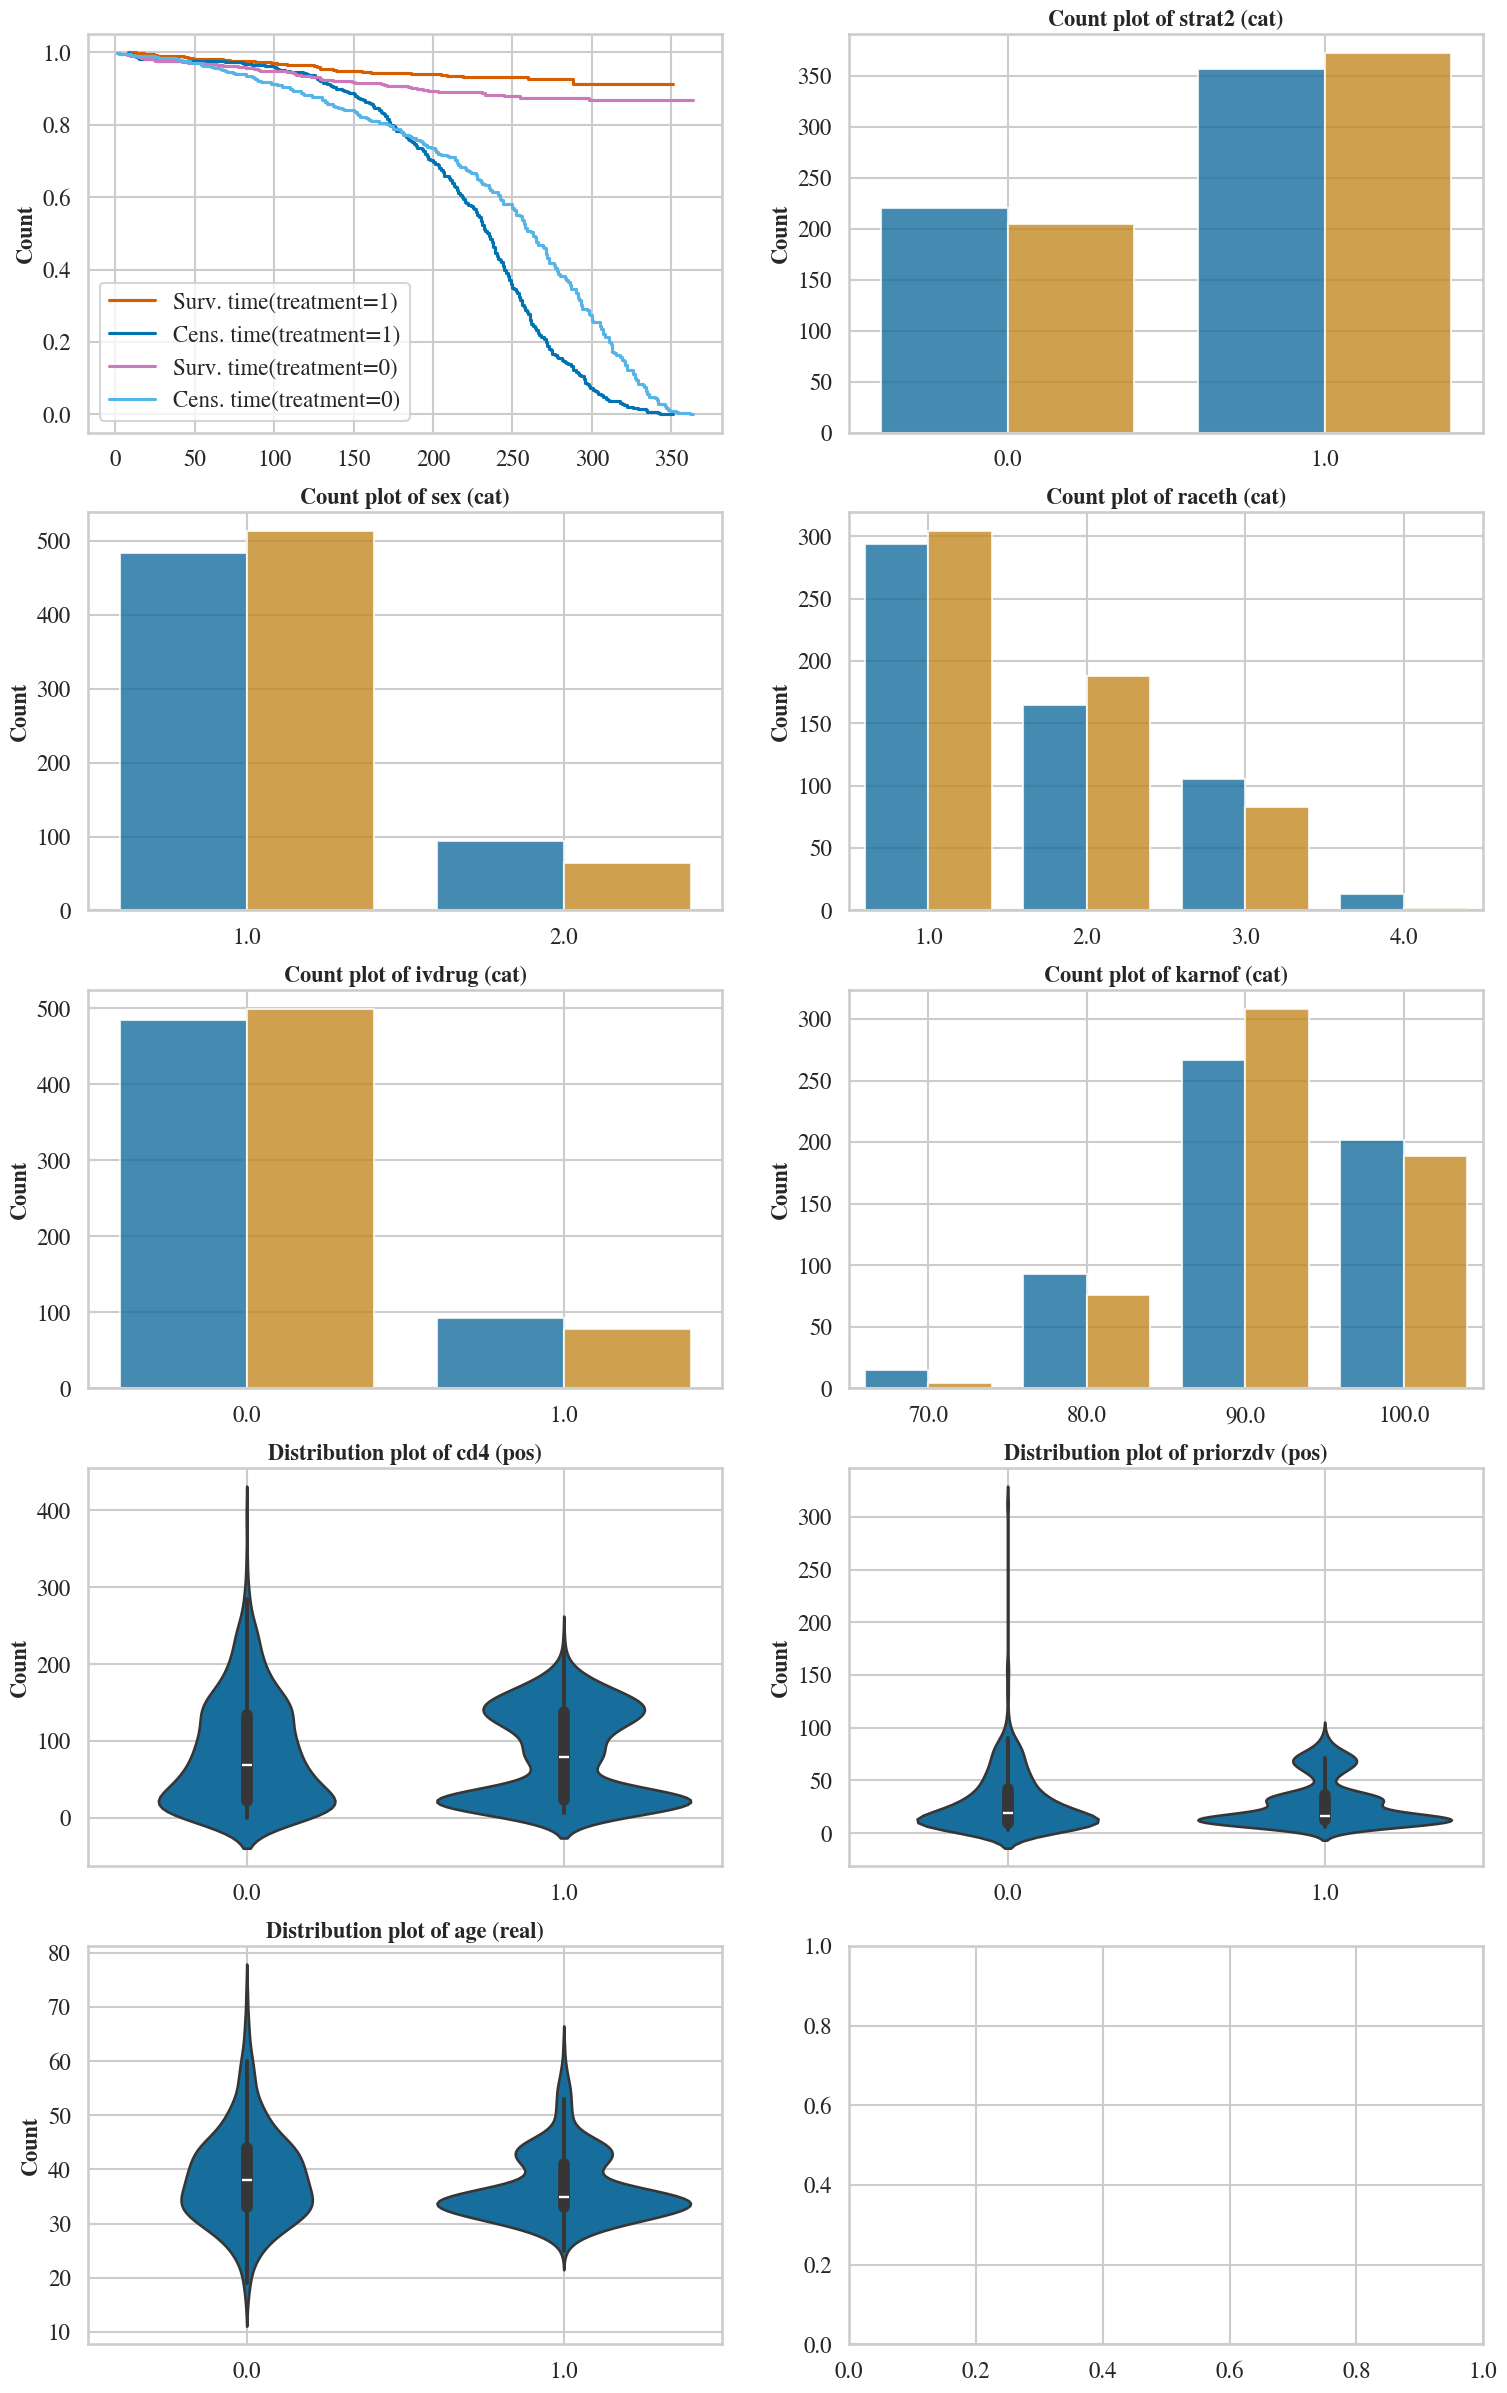

In [98]:
feat_types_dict_all = feat_types_dict.copy()#
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_all.to_numpy(),feat_types_dict_all,feat_comparison_name = 'treatment')

# Metrics data privacy etc ...

In [61]:
from synthcity.plugins import Plugins

Plugins(categories=["generic", "privacy", "survival_analysis"]).list()

[2025-04-07T10:14:29.999364+0200][18919][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


['tvae',
 'survival_nflow',
 'aim',
 'pategan',
 'survae',
 'decaf',
 'survival_ctgan',
 'arf',
 'dpgan',
 'bayesian_network',
 'ddpm',
 'ctgan',
 'dummy_sampler',
 'great',
 'uniform_sampler',
 'nflow',
 'privbayes',
 'adsgan',
 'survival_gan',
 'rtvae',
 'marginal_distributions']

In [62]:
from lifelines.datasets import load_rossi
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.plugins import Plugins

X = load_rossi()


data = SurvivalAnalysisDataLoader(
    X,
    target_column="arrest",
    time_to_event_column="week",
)

syn_model = Plugins().get("survival_gan")

syn_model.fit(data)

syn_model.generate(count=10)

[2025-04-07T10:14:52.721206+0200][18919][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-04-07T10:14:52.721206+0200][18919][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-04-07T10:14:52.873254+0200][18919][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  6%|██▌                                    | 649/10000 [00:52<12:31, 12.44it/s]


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,35,1,1,21,1,1,0,1,3
1,38,1,1,21,1,1,0,1,1
2,40,1,1,21,1,1,0,0,1
3,52,0,1,19,1,0,0,0,1
4,52,0,1,20,1,0,0,0,1
5,52,0,1,21,1,1,0,1,1
6,11,1,1,28,1,1,0,1,1
7,50,0,1,21,0,0,0,0,4
8,50,0,1,22,1,1,0,0,4
9,35,1,1,20,1,1,0,1,1


In [76]:
X = aids_control

data = SurvivalAnalysisDataLoader(
    X,
    target_column="censor",
    time_to_event_column="time",
)

In [77]:
syn_model = Plugins().get("survival_gan")

syn_model.fit(data)

control_SurvGAN = syn_model.generate(count=577)

[2025-04-07T13:51:09.312672+0200][18919][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-04-07T13:51:09.515977+0200][18919][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 16%|██████▎                               | 1649/10000 [02:56<14:55,  9.32it/s]


In [69]:
# synthcity absolute
from synthcity.benchmark import Benchmarks
loader= data
score = Benchmarks.evaluate(
    [("uniform_sampler", "uniform_sampler", {})],
    loader,
    synthetic_size=len(X),
    repeats=1,
)


[2025-04-07T10:33:51.530766+0200][18919][CRITICAL] module disabled: /home/lducrot/miniconda3/envs/_venv_312_conda_v2/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


In [70]:
Benchmarks.print(score)


Plugin : uniform_sampler


,min,max,mean,stddev,median,iqr,rounds,errors,durations
sanity.data_mismatch.score,0.272727,0.272727,0.272727,0.0,0.272727,0.0,1,0,0.00
sanity.common_rows_proportion.score,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1,0,0.00
sanity.nearest_syn_neighbor_distance.mean,0.281854,0.281854,0.281854,0.0,0.281854,0.0,1,0,0.00
sanity.close_values_probability.score,0.431034,0.431034,0.431034,0.0,0.431034,0.0,1,0,0.00
sanity.distant_values_probability.score,0.017241,0.017241,0.017241,0.0,0.017241,0.0,1,0,0.00
stats.jensenshannon_dist.marginal,0.057149,0.057149,0.057149,0.0,0.057149,0.0,1,0,0.02
stats.chi_squared_test.marginal,0.849487,0.849487,0.849487,0.0,0.849487,0.0,1,0,0.00
stats.inv_kl_divergence.marginal,0.812686,0.812686,0.812686,0.0,0.812686,0.0,1,0,0.00
stats.ks_test.marginal,0.638793,0.638793,0.638793,0.0,0.638793,0.0,1,0,0.00
stats.max_mean_discrepancy.joint,0.017241,0.017241,0.017241,0.0,0.017241,0.0,1,0,0.00


In [71]:
Benchmarks.highlight(score)

TypeError: DataFrame.set_axis() got an unexpected keyword argument 'inplace'